In [1]:
from IPython.display import Image

# Time Series Regression vs Basic Regression

In [3]:
Image(url= "https://miro.medium.com/v2/resize:fit:958/1*recDKo5CQiWQVDldEzLSfQ.png", width=700, height=500)

In Basic Regression, **the more data being used, the more regression model prove it's theory when the model is trying to fit to the model equation**
So, the difference between equation and data become smaller and smaller

But. the time series is different. **The more data being comes in, the larger error will be happen.** Why ?
Because the next t+1 uncertainty make prediction of t+2 more uncertain.

**The basic regression using the interpolation**, so the prediction will become more likely in between some range of data
**On the time series, we use extrapolation**, so it will be prediction outside of our range, it's make our prediction technique tricky

But. the time series is different. **The more data being comes in, the larger error will be happen.** Why ?
Because the next t+1 uncertainty make prediction of t+2 more uncertain.

# Import Dependency

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from numpy import hstack
import tensorflow as tf
from numpy import array
from datetime import datetime, timedelta
import matplotlib as mpl
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout, BatchNormalization, Activation
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

Matplotlib created a temporary cache directory at /var/folders/86/7gxks06s07xch2nsjg8bfzhh0000gn/T/matplotlib-4gw9j4ip because the default path (/Users/ingwerludwig/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Import Dataset

In [117]:
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
excel_path = os.path.join('Model Welang.xlsx')

In [9]:
df = pd.read_excel(excel_path,'Data')
df.rename(columns={'Unnamed: 0': 'DateTime'}, inplace=True)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.sort_values(by='DateTime',ascending=True,inplace=True)
df

,DateTime,RC,RL,LP,LD
0,2022-09-20 20:00:00,0.0,0.0,0.107,0.315
1,2022-09-20 21:00:00,0.0,0.0,0.108,0.307
2,2022-09-20 22:00:00,0.0,0.0,0.106,0.297
3,2022-09-20 23:00:00,0.0,0.0,0.108,0.293
4,2022-09-21 00:00:00,0.0,0.0,0.111,0.292
...,...,...,...,...,...
8611,2023-09-15 08:00:00,0.0,0.0,0.070,0.213
8612,2023-09-15 09:00:00,0.0,0.0,0.080,0.228
8613,2023-09-15 10:00:00,0.0,0.0,0.089,0.237
8614,2023-09-15 11:00:00,0.0,0.0,0.096,0.245


# Data Cleaning

Imputation : these methods fill in the missing values with estimated values.
There are 5 type of imputation :
1. Mean
2. Mode
3. Backward Fill
4. Forward Fill
 
Interpolation : **these methods use mathematical functions to estimate missing values based on the values of the surrounding observations**. The most popular ones are linear interpolation, polynomial interpolation, and spline interpolation

For now we choose to use Backward Fill

In [10]:
check_df = df['DateTime']
check_df = pd.DataFrame(check_df)

check_df['TimeDifference'] = check_df['DateTime'].diff()
expected_interval = pd.to_timedelta('1 hour')
check_df['not_sequential'] = check_df['TimeDifference'] != expected_interval

check_df.at[0, 'not_sequential'] = False
filtered_df = check_df[check_df['not_sequential']]
filtered_df

,DateTime,TimeDifference,not_sequential
14,2022-09-21 11:00:00,0 days 02:00:00,True
15,2022-09-21 13:00:00,0 days 02:00:00,True
17,2022-09-21 16:00:00,0 days 02:00:00,True
65,2022-09-23 17:00:00,0 days 02:00:00,True
1386,2022-11-17 21:00:00,0 days 04:00:00,True
2158,2022-12-20 04:00:00,0 days 04:00:00,True
4254,2023-03-17 13:00:00,0 days 02:00:00,True
4303,2023-03-19 17:00:00,0 days 04:00:00,True
4397,2023-03-23 17:00:00,0 days 03:00:00,True
4465,2023-03-26 14:00:00,0 days 02:00:00,True


In [154]:
start_date = df['DateTime'].min()
end_date = df['DateTime'].max()
date_range = pd.date_range(start=start_date, end=end_date, freq='1H')
sequence_df = pd.DataFrame({'DateTime': date_range})

df = pd.merge_asof(sequence_df, df, on='DateTime', direction='backward')

# Forward-fill missing values in the 'Akumulasi Curah Hujan Cendono' column
df['RC'].fillna(method='ffill', inplace=True)
df['RC'] = df['RC'].round(3).astype(float)

df['RL'].fillna(method='ffill', inplace=True)
df['RL'] = df['RL'].round(3).astype(float)

df['LP'].fillna(method='ffill', inplace=True)
df['LP'] = df['LP'].round(3).astype(float)

df['LD'].fillna(method='ffill', inplace=True)
df['LD'] = df['LD'].round(3).astype(float)
df

,DateTime,RC,RL,LP,LD
0,2022-09-20 20:00:00,0.00,0.00,0.11,0.32
1,2022-09-20 21:00:00,0.00,0.00,0.11,0.31
2,2022-09-20 22:00:00,0.00,0.00,0.11,0.30
3,2022-09-20 23:00:00,0.00,0.00,0.11,0.29
4,2022-09-21 00:00:00,0.00,0.00,0.11,0.29
...,...,...,...,...,...
8628,2023-09-15 08:00:00,0.00,0.00,0.07,0.21
8629,2023-09-15 09:00:00,0.00,0.00,0.08,0.23
8630,2023-09-15 10:00:00,0.00,0.00,0.09,0.24
8631,2023-09-15 11:00:00,0.00,0.00,0.10,0.24


In [155]:
check_df = df['DateTime']
check_df = pd.DataFrame(check_df)

check_df['TimeDifference'] = check_df['DateTime'].diff()
expected_interval = pd.to_timedelta('1 hour')
check_df['not_sequential'] = check_df['TimeDifference'] != expected_interval

# Fill the first row with False since it doesn't have a previous row for comparison
check_df.at[0, 'not_sequential'] = False
filtered_df = check_df[check_df['not_sequential']]
filtered_df

,DateTime,TimeDifference,not_sequential


In [7]:
df.to_excel('Fix Data_Model Welang.xlsx')

# Data Preprocessing

**Stationary**: A dataset should follow the below **thumb rules without having Trend, Seasonality, Cyclical, and Irregularity components** of the time series.
**Mean** must be **constant**
**Standard Deviation** must be constant


# Import Cleaned Dataset

In [206]:
import os
excel_path = os.path.join(os.getcwd(), 'Fix Data_Model Welang.xlsx')

In [207]:
merge_df = pd.read_excel(excel_path)
merge_df.drop('Unnamed: 0',axis=1,inplace=True)
merge_df['DateTime'] = pd.to_datetime(merge_df['DateTime'])
merge_df.sort_values(by='DateTime',ascending=True,inplace=True)
merge_df.head(5)

,DateTime,RC,RL,LP,LD
0,2022-09-20 20:00:00,0.00,0.00,0.11,0.32
1,2022-09-20 21:00:00,0.00,0.00,0.11,0.31
2,2022-09-20 22:00:00,0.00,0.00,0.11,0.30
3,2022-09-20 23:00:00,0.00,0.00,0.11,0.29
4,2022-09-21 00:00:00,0.00,0.00,0.11,0.29


# Check The ACF of LP and LD

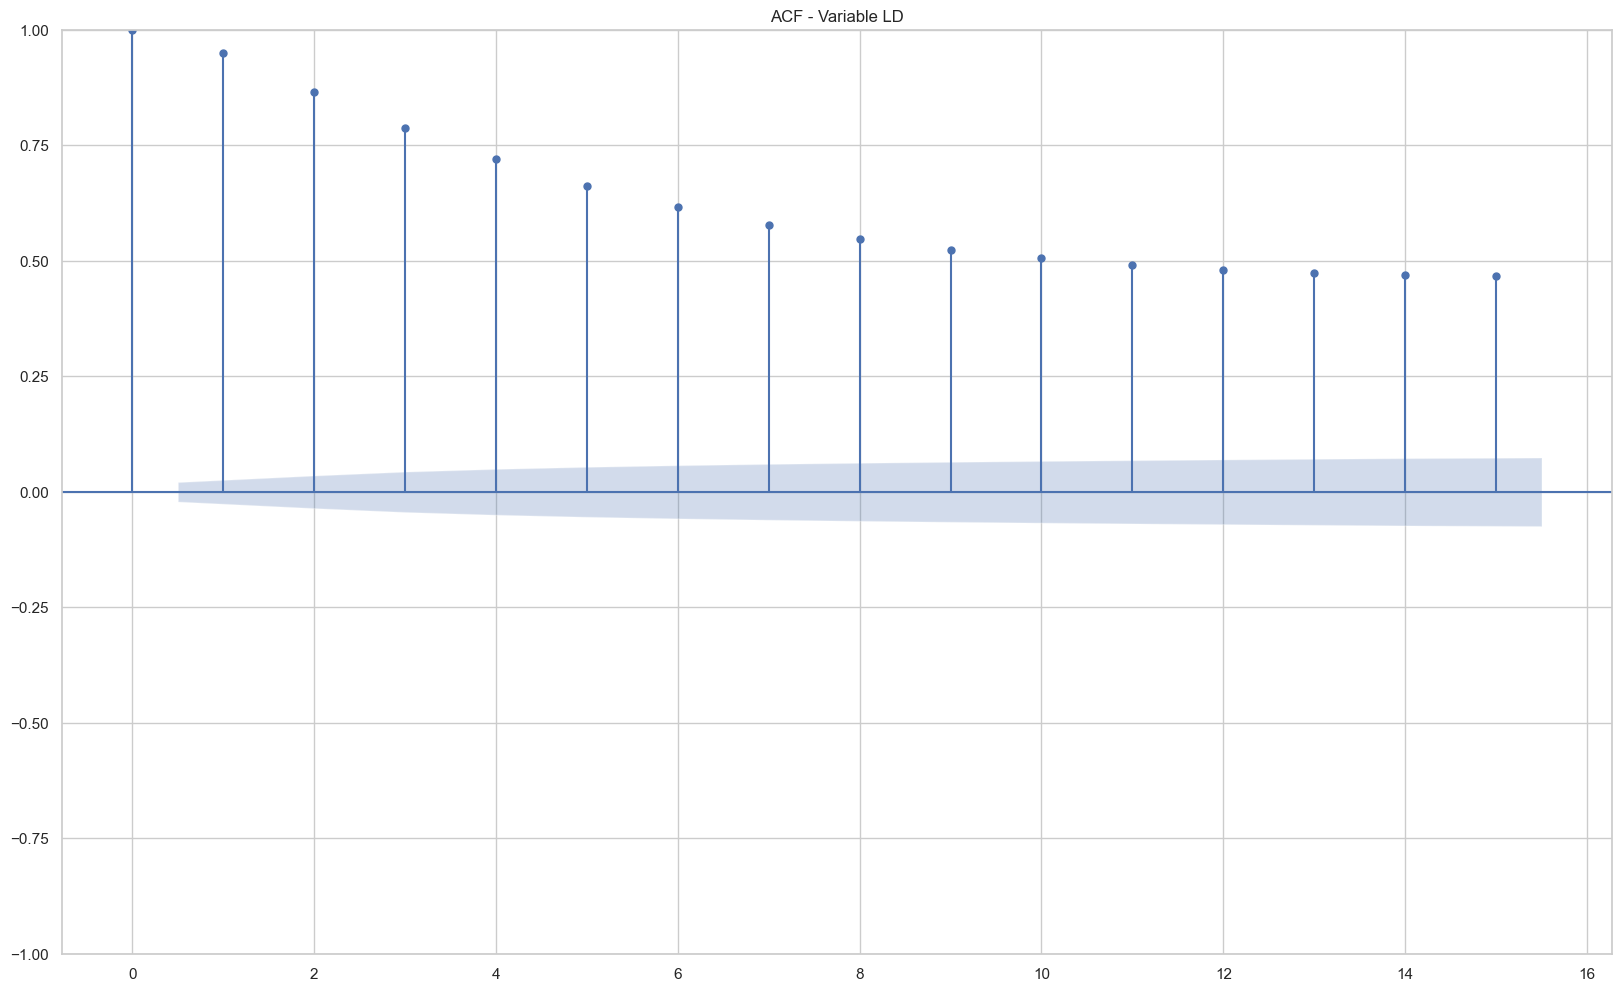

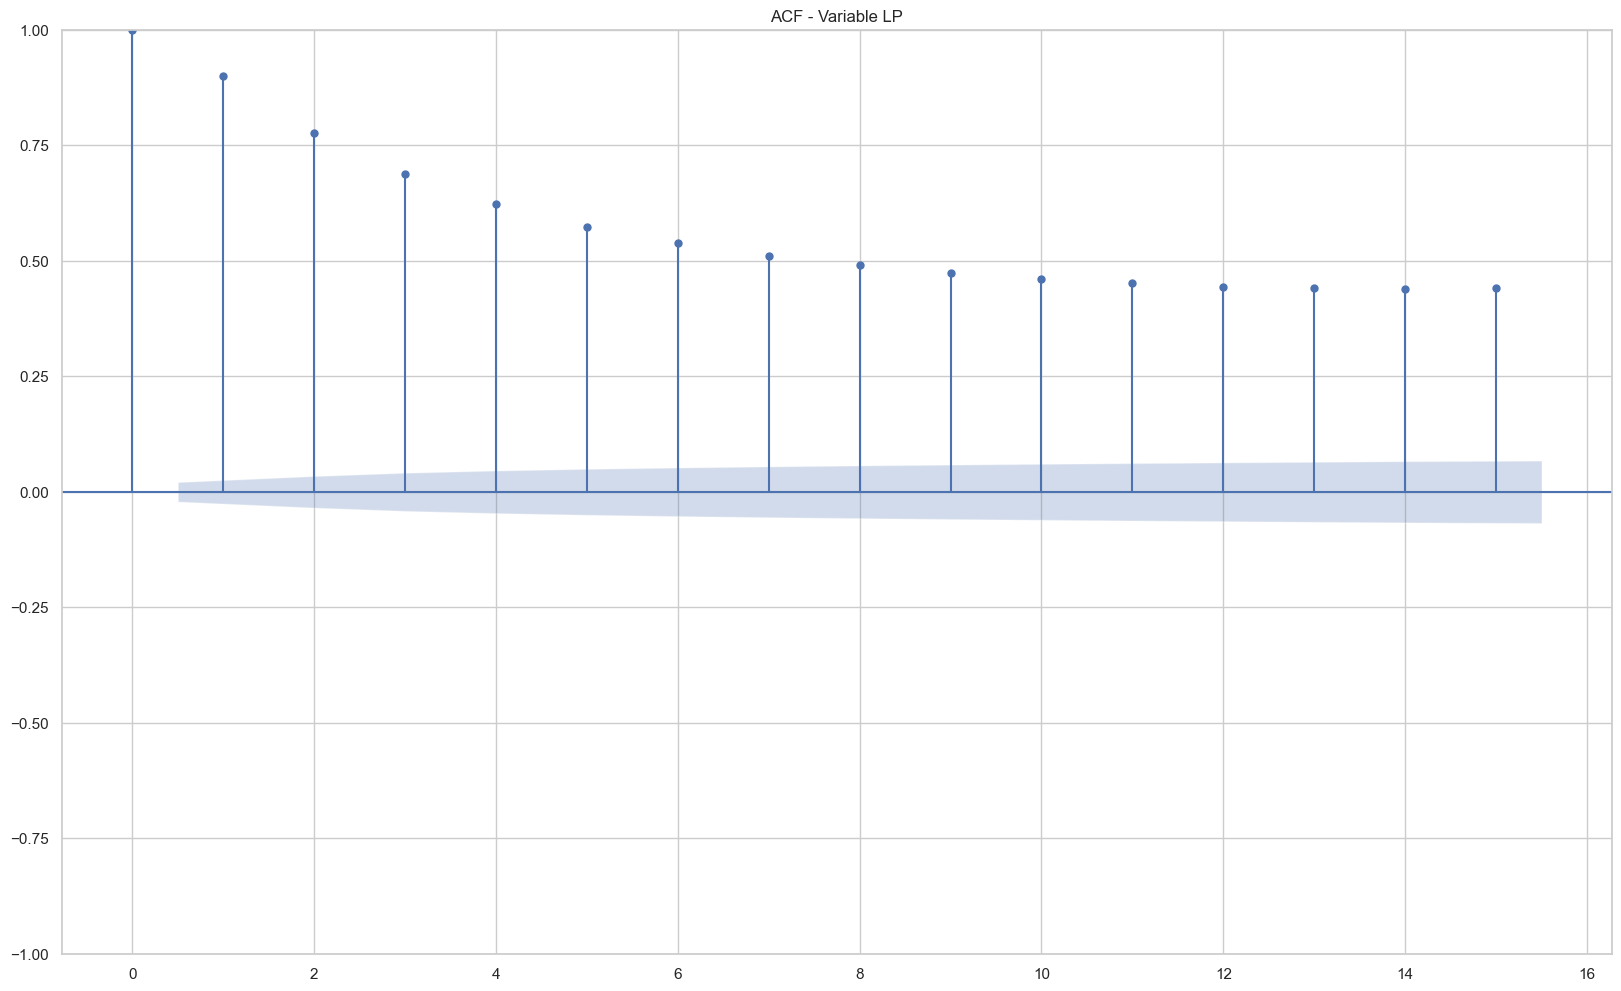

In [208]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

columns_to_analyze = merge_df.columns.difference(['DateTime','RC','RL'])
lags = 15

for i, column in enumerate(columns_to_analyze):
    fig, ax = plt.subplots(figsize=(20, 12))
    plot_acf(merge_df[column], lags=lags, ax=ax)
    ax.set_title(f'ACF - Variable {column}')
    plt.show()

# Check The PACF of LP and LD

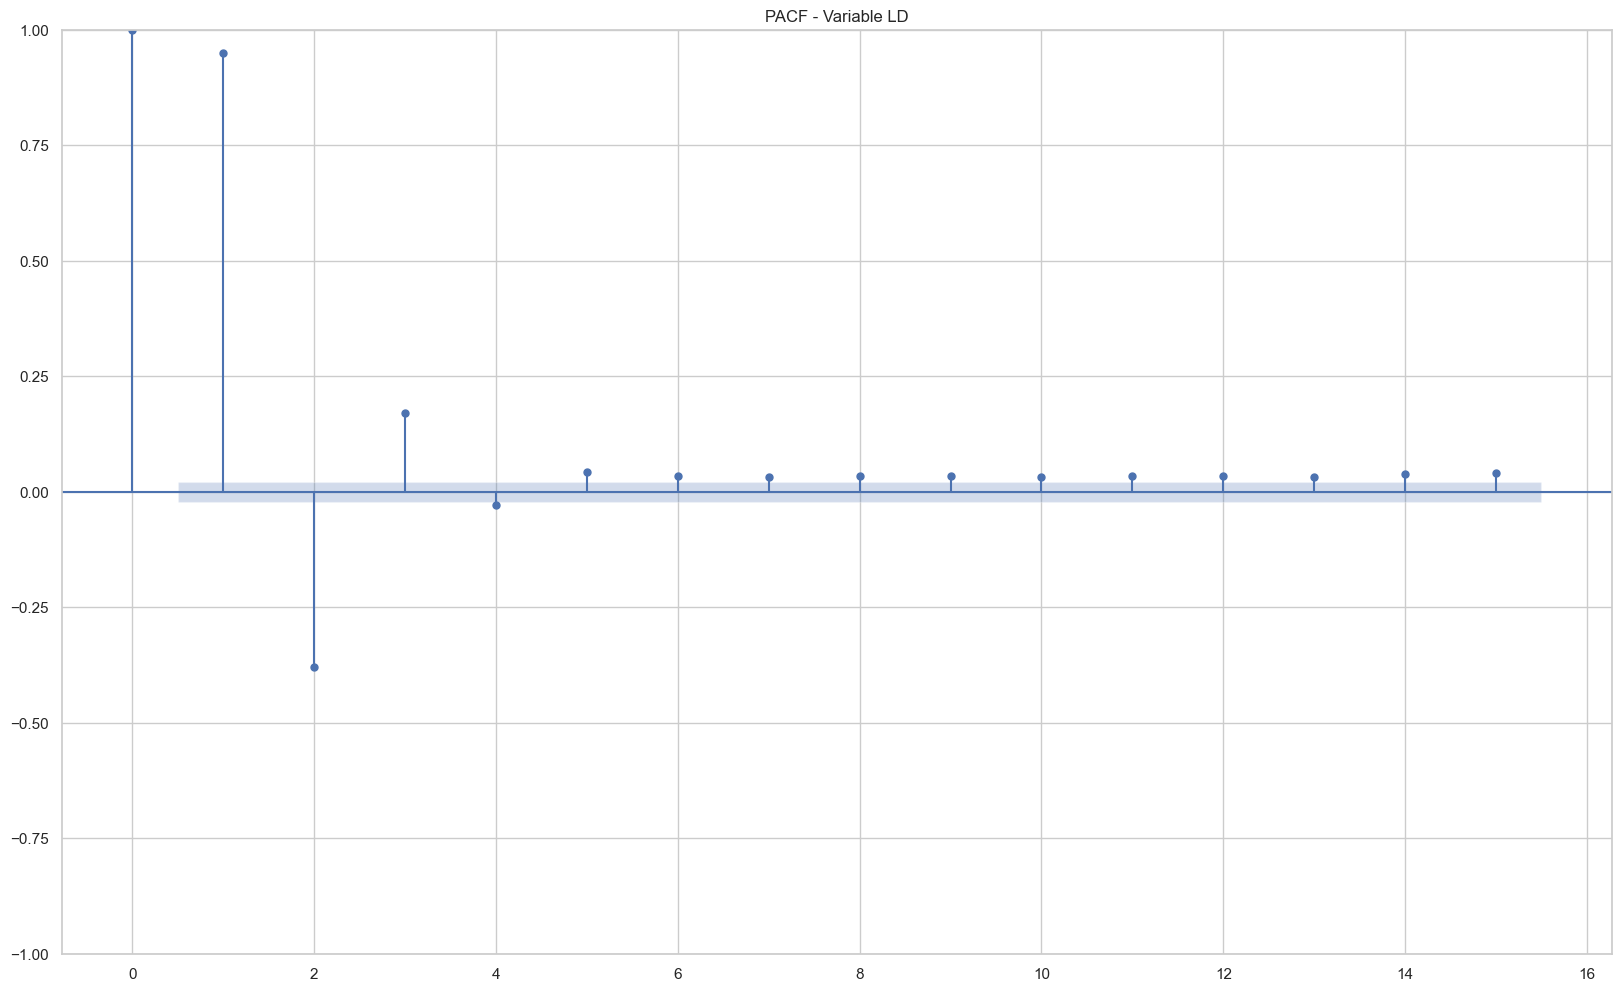

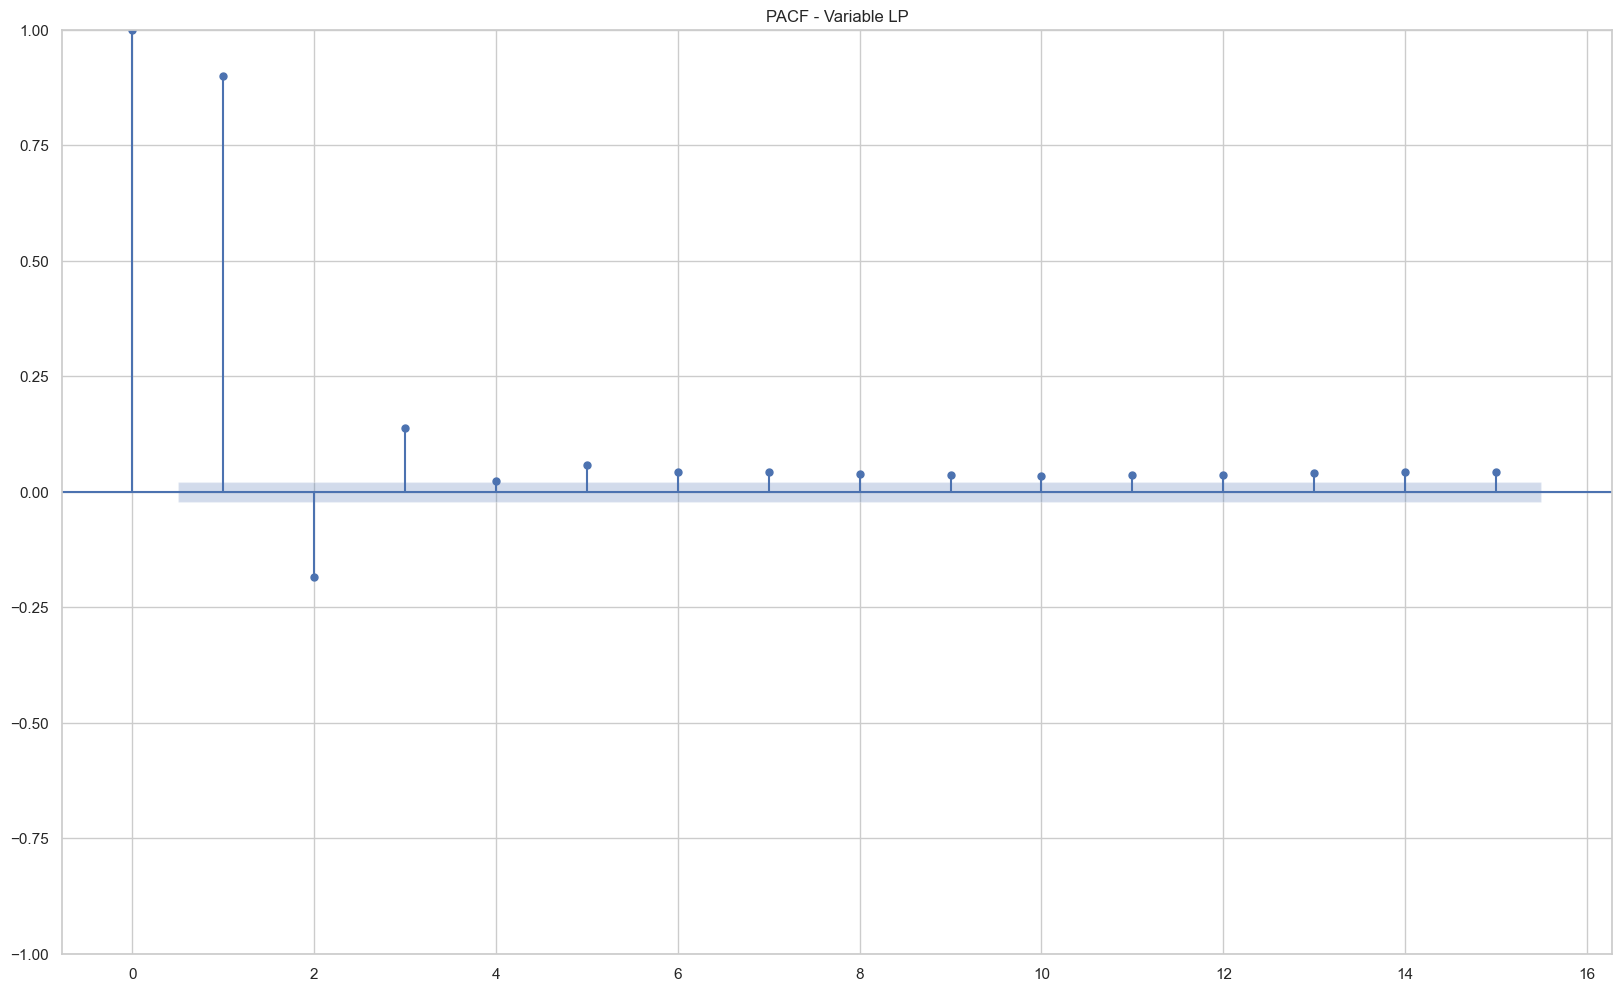

In [209]:
for i, column in enumerate(columns_to_analyze):
    fig, ax = plt.subplots(figsize=(20, 12))
    plot_pacf(merge_df[column], lags=lags, ax=ax)
    ax.set_title(f'PACF - Variable {column}')
    plt.show()

# EDA

## EDA of RL

In [210]:
from statsmodels.tsa.seasonal import seasonal_decompose
copy_df_2 = merge_df.iloc[48:600,:]
copy_df_2 = copy_df_2.set_index('DateTime')
copy_df_2.index.freq = 'H'

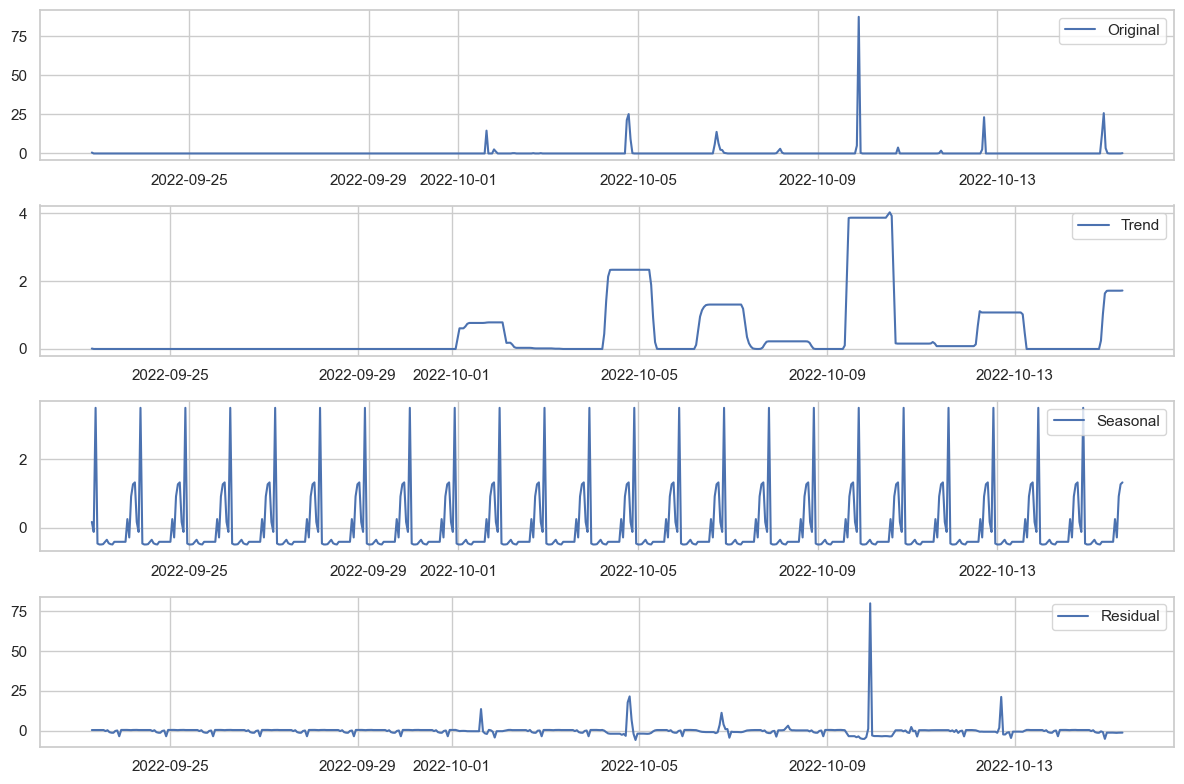

In [211]:
results = seasonal_decompose(copy_df_2['RL'])

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(copy_df_2['RL'], label='Original')
plt.legend()

plt.subplot(412)
plt.plot(results.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(results.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(results.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


### Remove Seasonality of RL

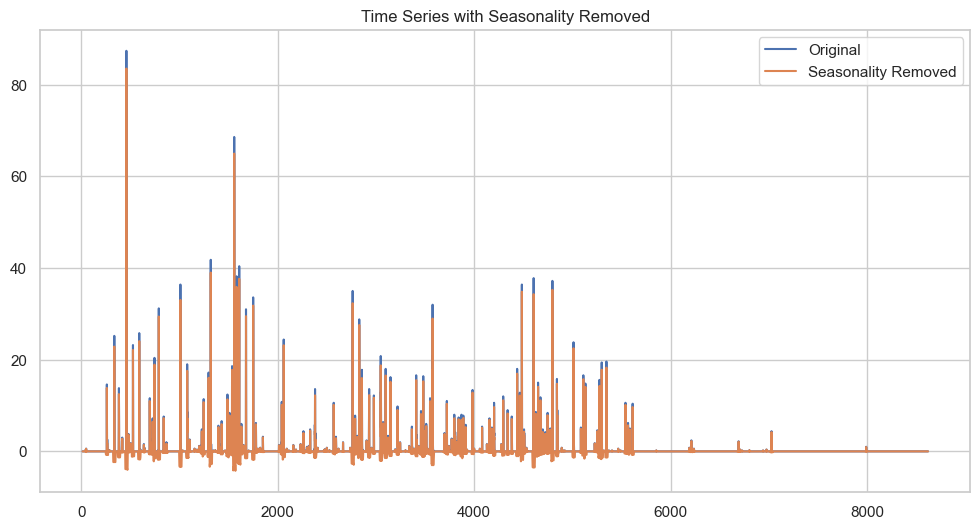

In [186]:
window_size = 24
merge_df['rolling_mean_RL'] = merge_df['RL'].rolling(window=window_size, center=True).mean()
merge_df.dropna(inplace=True)
merge_df['new_RL'] = merge_df['RL'] - merge_df['rolling_mean_RL']
plt.figure(figsize=(12, 6))
plt.plot(merge_df['RL'], label='Original')
plt.plot(merge_df['new_RL'], label='Seasonality Removed')
plt.title('Time Series with Seasonality Removed')
plt.legend()
plt.show()

## EDA of RC

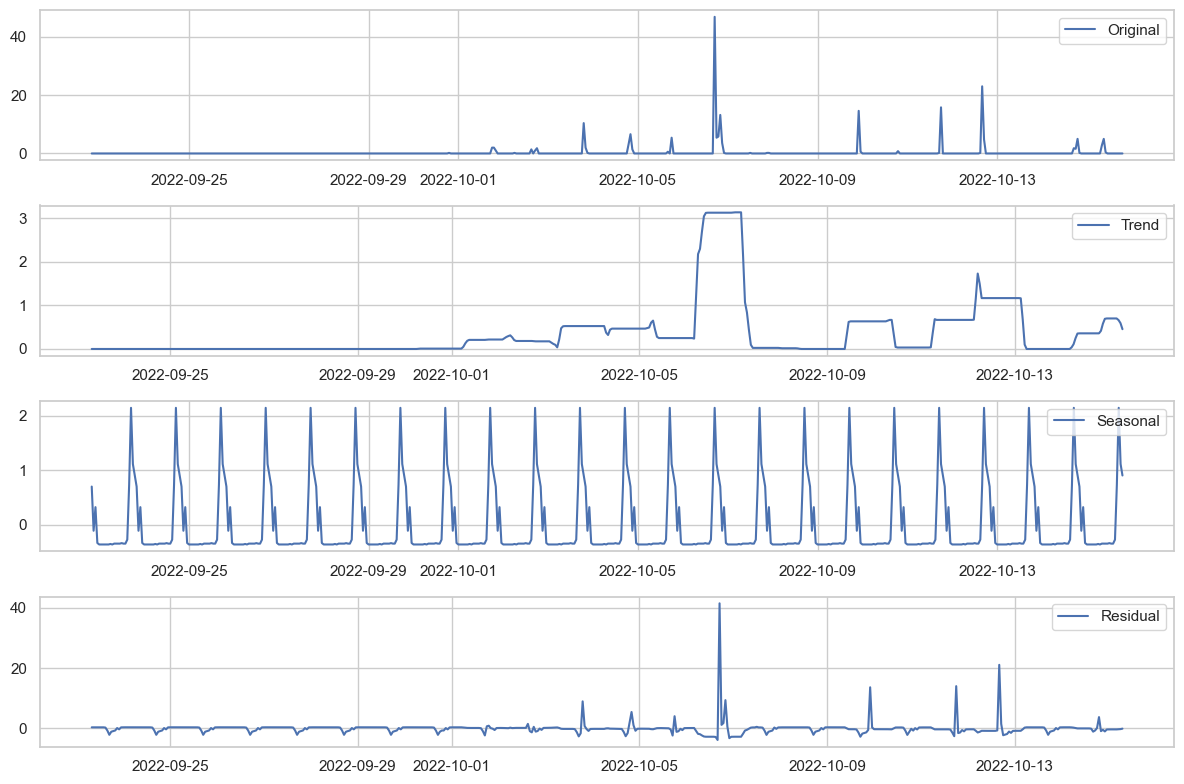

In [212]:
copy_df_2 = merge_df.iloc[48:600,:]
copy_df_2 = copy_df_2.set_index('DateTime')
copy_df_2.index.freq = 'H'
results = seasonal_decompose(copy_df_2['RC'],period=None)

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(copy_df_2['RC'], label='Original')
plt.legend()

plt.subplot(412)
plt.plot(results.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(results.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(results.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


### Remove Seasonality of RC

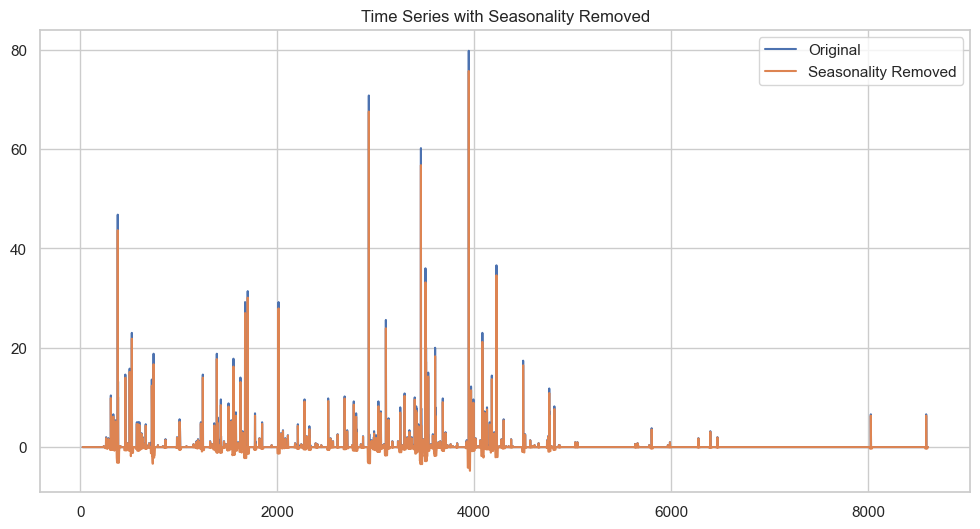

In [188]:
window_size = 24
merge_df['rolling_mean_RC'] = merge_df['RC'].rolling(window=window_size, center=True).mean()
merge_df.dropna(inplace=True)
merge_df['new_RC'] = merge_df['RC'] - merge_df['rolling_mean_RC']
plt.figure(figsize=(12, 6))
plt.plot(merge_df['RC'], label='Original')
plt.plot(merge_df['new_RC'], label='Seasonality Removed')
plt.title('Time Series with Seasonality Removed')
plt.legend()
plt.show()

## EDA of LP

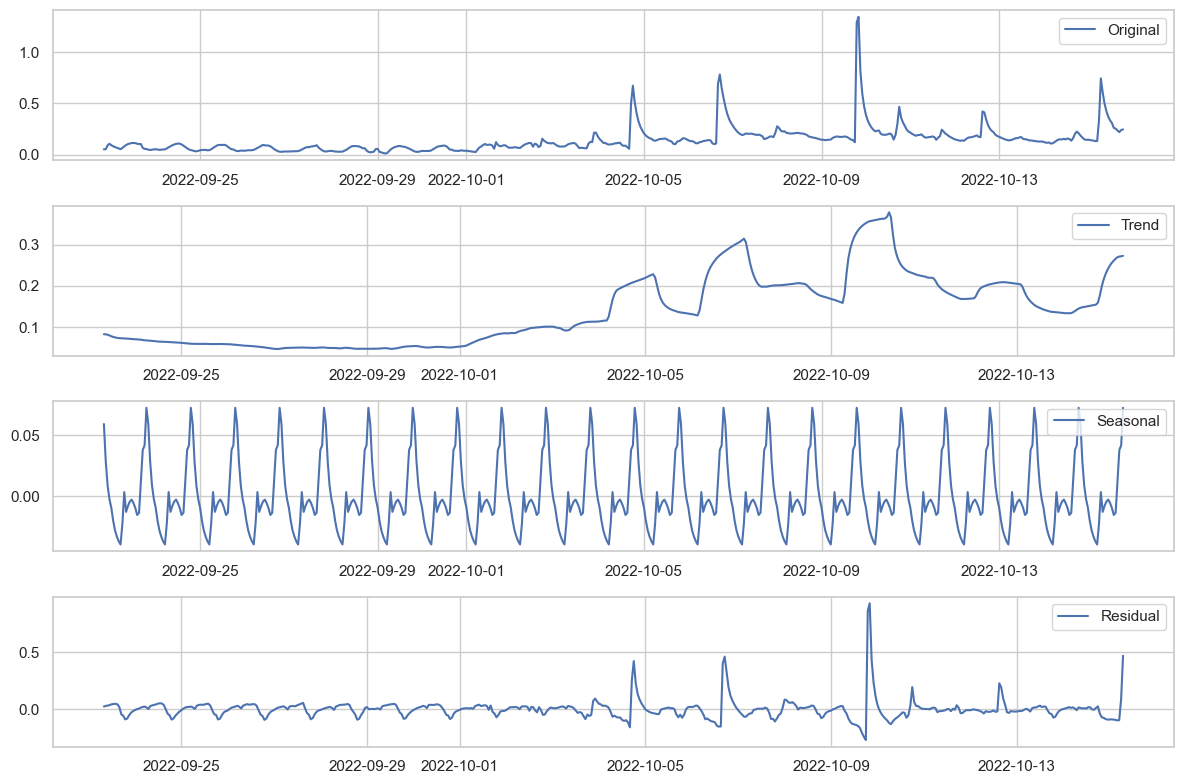

In [213]:
copy_df_2 = merge_df.iloc[48:600,:]
copy_df_2 = copy_df_2.set_index('DateTime')
copy_df_2.index.freq = 'H'
results = seasonal_decompose(copy_df_2['LP'],period=None)

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(copy_df_2['LP'], label='Original')
plt.legend()

plt.subplot(412)
plt.plot(results.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(results.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(results.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


### Remove Seasonality of LP

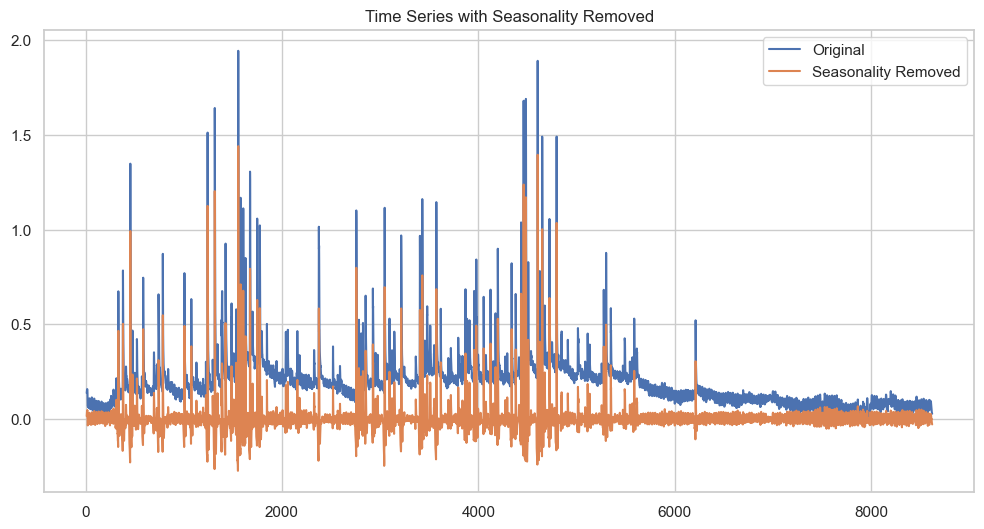

In [214]:
window_size = 24
merge_df['rolling_mean_LP'] = merge_df['LP'].rolling(window=window_size, center=True).mean()
merge_df.dropna(inplace=True)
merge_df['new_LP'] = merge_df['LP'] - merge_df['rolling_mean_LP']
plt.figure(figsize=(12, 6))
plt.plot(merge_df['LP'], label='Original')
plt.plot(merge_df['new_LP'], label='Seasonality Removed')
plt.title('Time Series with Seasonality Removed')
plt.legend()
plt.show()

## EDA of LD

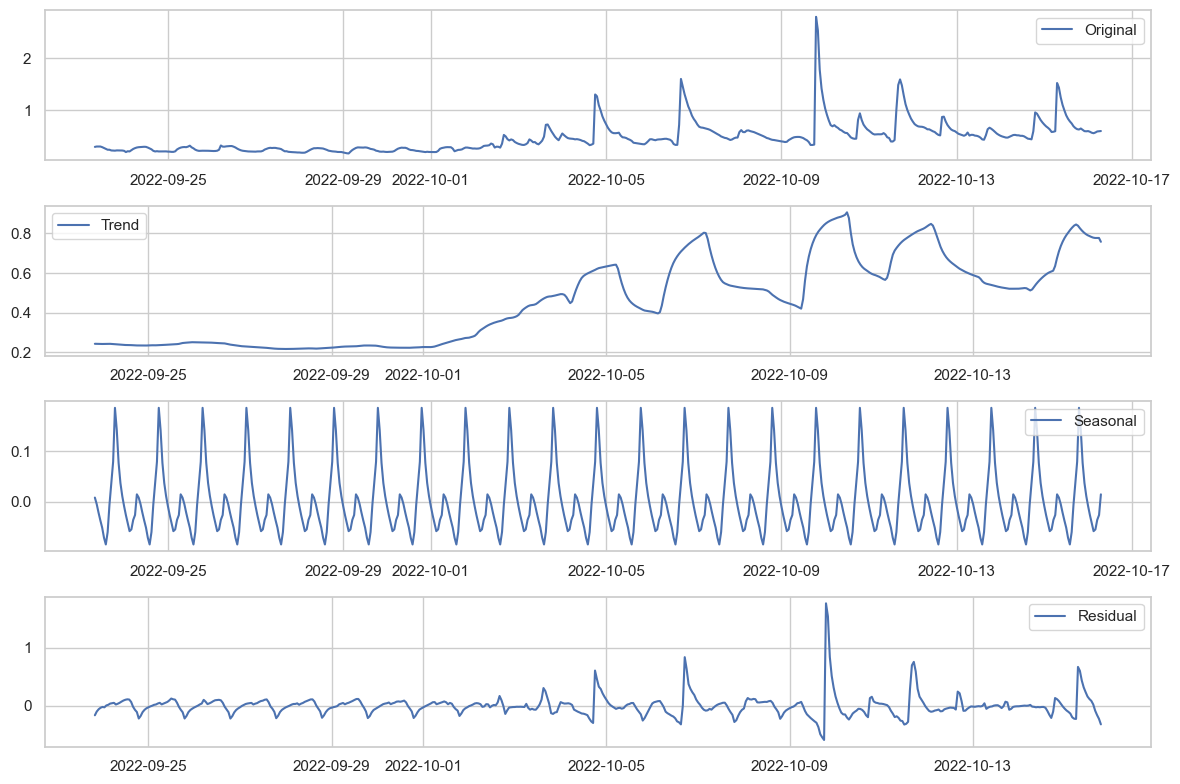

In [215]:
copy_df_2 = merge_df.iloc[48:600,:]
copy_df_2 = copy_df_2.set_index('DateTime')
copy_df_2.index.freq = 'H'
results = seasonal_decompose(copy_df_2['LD'],period=None)

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(copy_df_2['LD'], label='Original')
plt.legend()

plt.subplot(412)
plt.plot(results.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(results.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(results.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


### Remove Seasonality of LD

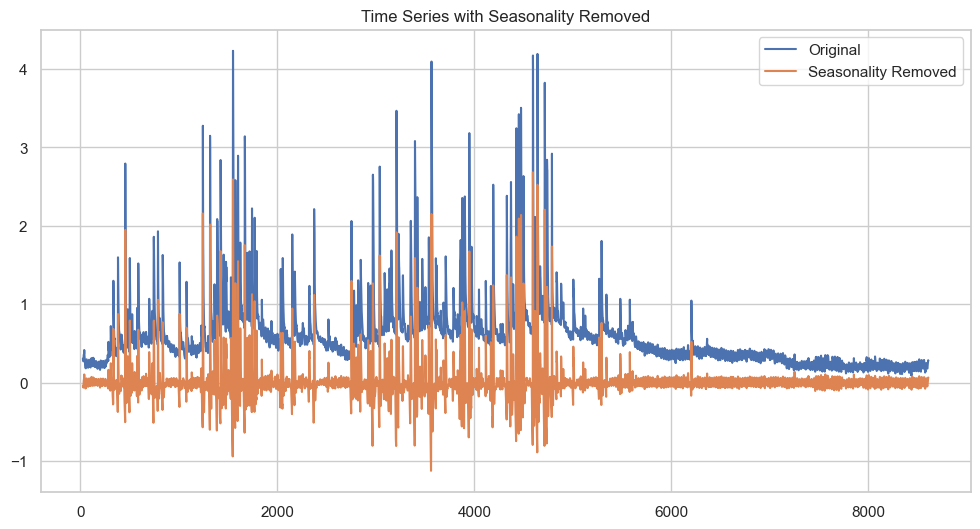

In [216]:
window_size = 24
merge_df['rolling_mean_LD'] = merge_df['LD'].rolling(window=window_size, center=True).mean()
merge_df.dropna(inplace=True)
merge_df['new_LD'] = merge_df['LD'] - merge_df['rolling_mean_LD']
plt.figure(figsize=(12, 6))
plt.plot(merge_df['LD'], label='Original')
plt.plot(merge_df['new_LD'], label='Seasonality Removed')
plt.title('Time Series with Seasonality Removed')
plt.legend()
plt.show()

In [193]:
rows_without_null = merge_df[merge_df.notnull().all(axis=1)]
rows_without_null

,DateTime,RC,RL,LP,LD,rolling_mean_RL,new_RL,rolling_mean_RC,new_RC,rolling_mean_LP,new_LP,rolling_mean_LD,new_LD
48,2022-09-22 20:00:00,0.00,0.60,0.05,0.22,0.04,0.56,0.00,0.00,0.08,-0.03,0.27,-0.05
49,2022-09-22 21:00:00,0.00,0.00,0.05,0.21,0.04,-0.04,0.00,0.00,0.08,-0.03,0.27,-0.06
50,2022-09-22 22:00:00,0.00,0.00,0.09,0.20,0.04,-0.04,0.00,0.00,0.08,0.01,0.27,-0.07
51,2022-09-22 23:00:00,0.00,0.00,0.11,0.19,0.04,-0.04,0.00,0.00,0.08,0.03,0.26,-0.07
52,2022-09-23 00:00:00,0.00,0.00,0.09,0.19,0.04,-0.04,0.00,0.00,0.08,0.01,0.26,-0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8584,2023-09-13 12:00:00,0.00,0.00,0.10,0.19,0.00,0.00,0.27,-0.27,0.07,0.03,0.19,0.00
8585,2023-09-13 13:00:00,0.00,0.00,0.10,0.21,0.00,0.00,0.27,-0.27,0.07,0.03,0.19,0.02
8586,2023-09-13 14:00:00,0.00,0.00,0.10,0.23,0.00,0.00,0.27,-0.27,0.07,0.03,0.19,0.04
8587,2023-09-13 15:00:00,0.00,0.00,0.09,0.24,0.00,0.00,0.27,-0.27,0.07,0.02,0.19,0.05


# Check Data Stationary

In [217]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

result = adfuller(rows_without_null['new_LP'])
result_kpss = kpss(rows_without_null['new_LP'])

test_statistic = result[0]
p_value = result[1]

test_statistic_kpss = result_kpss[0]
p_value_kpss = result_kpss[1]
lags_used_kpss = result_kpss[2]

print(f'Test Statistic Adfuller: {test_statistic:.8f}')
print(f'P-value Adfuller: {p_value:.8f}')
print(f'Test Statistic (KPSS): {test_statistic_kpss:.8f}')
print(f'P-value (KPSS): {p_value_kpss:.8f}')
print(f'Lags Used (KPSS): {lags_used_kpss}')

warnings.resetwarnings()

Test Statistic Adfuller: -27.26969166
P-value Adfuller: 0.00000000
Test Statistic (KPSS): 0.00202009
P-value (KPSS): 0.10000000
Lags Used (KPSS): 25


In [218]:
warnings.simplefilter('ignore', InterpolationWarning)
result = adfuller(rows_without_null['new_LD'])
result_kpss = kpss(rows_without_null['new_LD'])

test_statistic = result[0]
p_value = result[1]

test_statistic_kpss = result_kpss[0]
p_value_kpss = result_kpss[1]
lags_used_kpss = result_kpss[2]

print(f'Test Statistic Adfuller: {test_statistic:.8f}')
print(f'P-value Adfuller: {p_value:.8f}')
print(f'Test Statistic (KPSS): {test_statistic_kpss:.8f}')
print(f'P-value (KPSS): {p_value_kpss:.8f}')
print(f'Lags Used (KPSS): {lags_used_kpss}')

warnings.resetwarnings()

Test Statistic Adfuller: -28.07101431
P-value Adfuller: 0.00000000
Test Statistic (KPSS): 0.00039923
P-value (KPSS): 0.10000000
Lags Used (KPSS): 7


In [196]:
warnings.simplefilter('ignore', InterpolationWarning)
result = adfuller(rows_without_null['new_RC'])
result_kpss = kpss(rows_without_null['new_RC'])

test_statistic = result[0]
p_value = result[1]

test_statistic_kpss = result_kpss[0]
p_value_kpss = result_kpss[1]
lags_used_kpss = result_kpss[2]

print(f'Test Statistic Adfuller: {test_statistic:.8f}')
print(f'P-value Adfuller: {p_value:.8f}')
print(f'Test Statistic (KPSS): {test_statistic_kpss:.8f}')
print(f'P-value (KPSS): {p_value_kpss:.8f}')
print(f'Lags Used (KPSS): {lags_used_kpss}')

warnings.resetwarnings()

Test Statistic Adfuller: -26.87705734
P-value Adfuller: 0.00000000
Test Statistic (KPSS): 0.00591285
P-value (KPSS): 0.10000000
Lags Used (KPSS): 74


In [197]:
warnings.simplefilter('ignore', InterpolationWarning)
result = adfuller(rows_without_null['new_RL'])
result_kpss = kpss(rows_without_null['new_RL'])

test_statistic = result[0]
p_value = result[1]

test_statistic_kpss = result_kpss[0]
p_value_kpss = result_kpss[1]
lags_used_kpss = result_kpss[2]

print(f'Test Statistic Adfuller: {test_statistic:.8f}')
print(f'P-value Adfuller: {p_value:.8f}')
print(f'Test Statistic (KPSS): {test_statistic_kpss:.8f}')
print(f'P-value (KPSS): {p_value_kpss:.8f}')
print(f'Lags Used (KPSS): {lags_used_kpss}')

warnings.resetwarnings()

Test Statistic Adfuller: -26.96606325
P-value Adfuller: 0.00000000
Test Statistic (KPSS): 0.00426951
P-value (KPSS): 0.10000000
Lags Used (KPSS): 80


# Remove Column and Shifted Value

In [219]:
merge_df.head(5)

,DateTime,RC,RL,LP,LD,rolling_mean_LP,new_LP,rolling_mean_LD,new_LD
24,2022-09-21 20:00:00,0.00,0.00,0.07,0.31,0.10,-0.03,0.35,-0.04
25,2022-09-21 21:00:00,0.00,0.00,0.07,0.30,0.10,-0.03,0.34,-0.05
26,2022-09-21 22:00:00,0.00,0.00,0.07,0.29,0.09,-0.02,0.34,-0.05
27,2022-09-21 23:00:00,0.00,0.00,0.07,0.29,0.09,-0.03,0.34,-0.05
28,2022-09-22 00:00:00,0.00,0.00,0.06,0.29,0.09,-0.03,0.34,-0.05


In [220]:
print(merge_df.shape[0])
print(merge_df.shape[1])

8587
9


In [221]:
rows_with_null = merge_df[merge_df.isnull().any(axis=1)]
rows_with_null

,DateTime,RC,RL,LP,LD,rolling_mean_LP,new_LP,rolling_mean_LD,new_LD


In [222]:
# merge_df.drop(['RC','RL','LP','LD'],axis=1,inplace=True)
# merge_df.dropna(inplace=True)
# print(merge_df.shape[0])
# print(merge_df.shape[1])

In [223]:
rows_with_null = merge_df[merge_df.isnull().any(axis=1)]
rows_with_null

,DateTime,RC,RL,LP,LD,rolling_mean_LP,new_LP,rolling_mean_LD,new_LD


In [224]:
merge_df.tail(5)

,DateTime,RC,RL,LP,LD,rolling_mean_LP,new_LP,rolling_mean_LD,new_LD
8606,2023-09-14 10:00:00,0.00,0.00,0.09,0.25,0.07,0.01,0.23,0.03
8607,2023-09-14 11:00:00,0.00,0.00,0.09,0.27,0.07,0.01,0.22,0.05
8608,2023-09-14 12:00:00,0.00,0.00,0.09,0.29,0.07,0.03,0.22,0.06
8609,2023-09-14 13:00:00,0.00,0.00,0.09,0.29,0.07,0.02,0.22,0.07
8610,2023-09-14 14:00:00,0.00,0.00,0.09,0.28,0.06,0.02,0.22,0.06


# Multivariate Sliding Window

In [225]:
def split_sequences_sliding(sequences, n_steps_in, n_steps_out, step=1):
    X, y = list(), list()
    for i in range(0, len(sequences) - n_steps_in - n_steps_out + 1, step):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# Applying Sliding Window

In [226]:
columns_to_use = ['new_LD', 'new_LP', 'RC', 'RL']
preprocessed_df = merge_df[columns_to_use]

In [227]:
n_steps_in, n_steps_out = 5, 5
train_percent, validation_percent = 0.7, 0.2

x_data, y_data = split_sequences_sliding(preprocessed_df.to_numpy(), n_steps_in, n_steps_out)

# Train Test Split

In [228]:
from sklearn.model_selection import train_test_split
x_for_training_and_val, x_test, y_for_training_and_val, y_test = train_test_split(x_data, y_data, test_size=1-train_percent-validation_percent)
x_train, x_validation, y_train, y_validation = train_test_split(x_for_training_and_val, y_for_training_and_val, test_size=0.23)

In [229]:
y_test = y_test[:, :, -1].reshape(-1, n_steps_out)
y_train = y_train[:, :, -1].reshape(-1, n_steps_out)
y_validation = y_validation[:, :, -1].reshape(-1, n_steps_out)

In [230]:
print('Data for train:', x_train.shape, y_train.shape)
print('Total days for train:', x_train.shape[0] / 24)
print('\nData for validation:', x_validation.shape, y_validation.shape)
print('Total days for validation:', x_validation.shape[0]  / 24)
print('\nData for test:', x_test.shape, y_test.shape)
print('Total days for test:', x_test.shape[0]  / 24)

Data for train: (5944, 5, 4) (5944, 5)
Total days for train: 247.66666666666666

Data for validation: (1776, 5, 4) (1776, 5)
Total days for validation: 74.0

Data for test: (858, 5, 4) (858, 5)
Total days for test: 35.75


# Plotting the Data

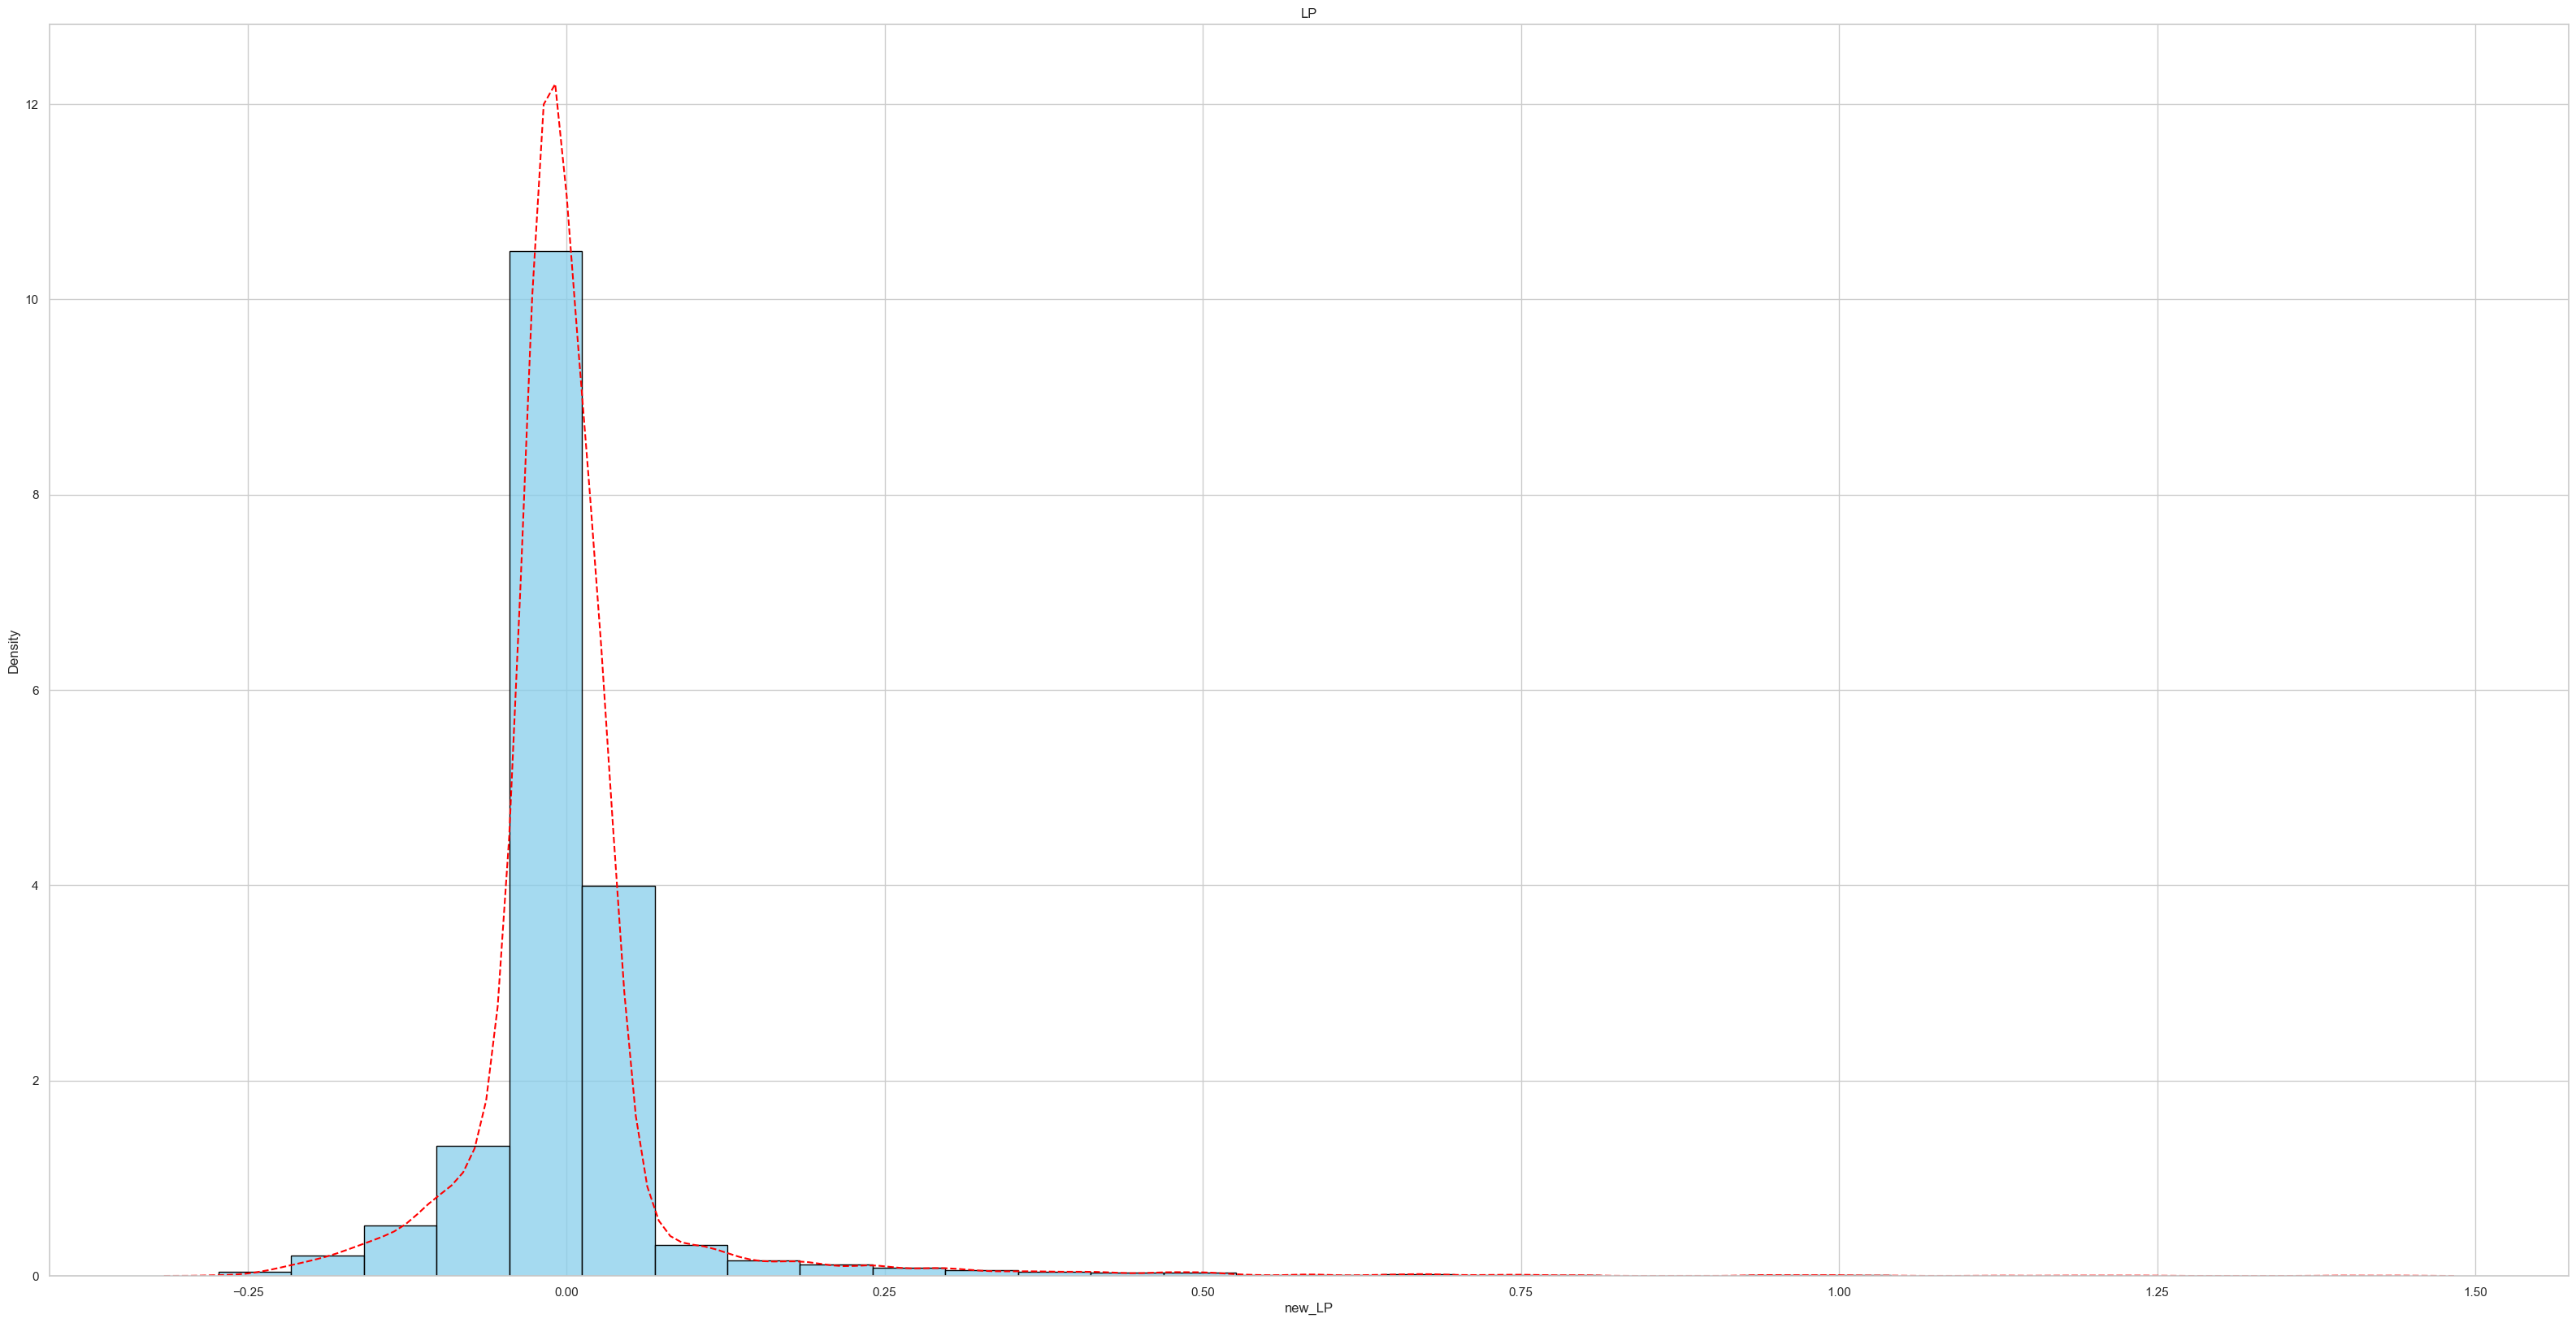

In [231]:
import seaborn as sns
sns.set(style="whitegrid")
sns.histplot(merge_df['new_LP'], kde=False, color='skyblue', edgecolor='black', bins=30, stat='density')
sns.kdeplot(merge_df['new_LP'], color='red', linestyle='--')

plt.title('LP')
plt.ylabel('Density')
plt.show()

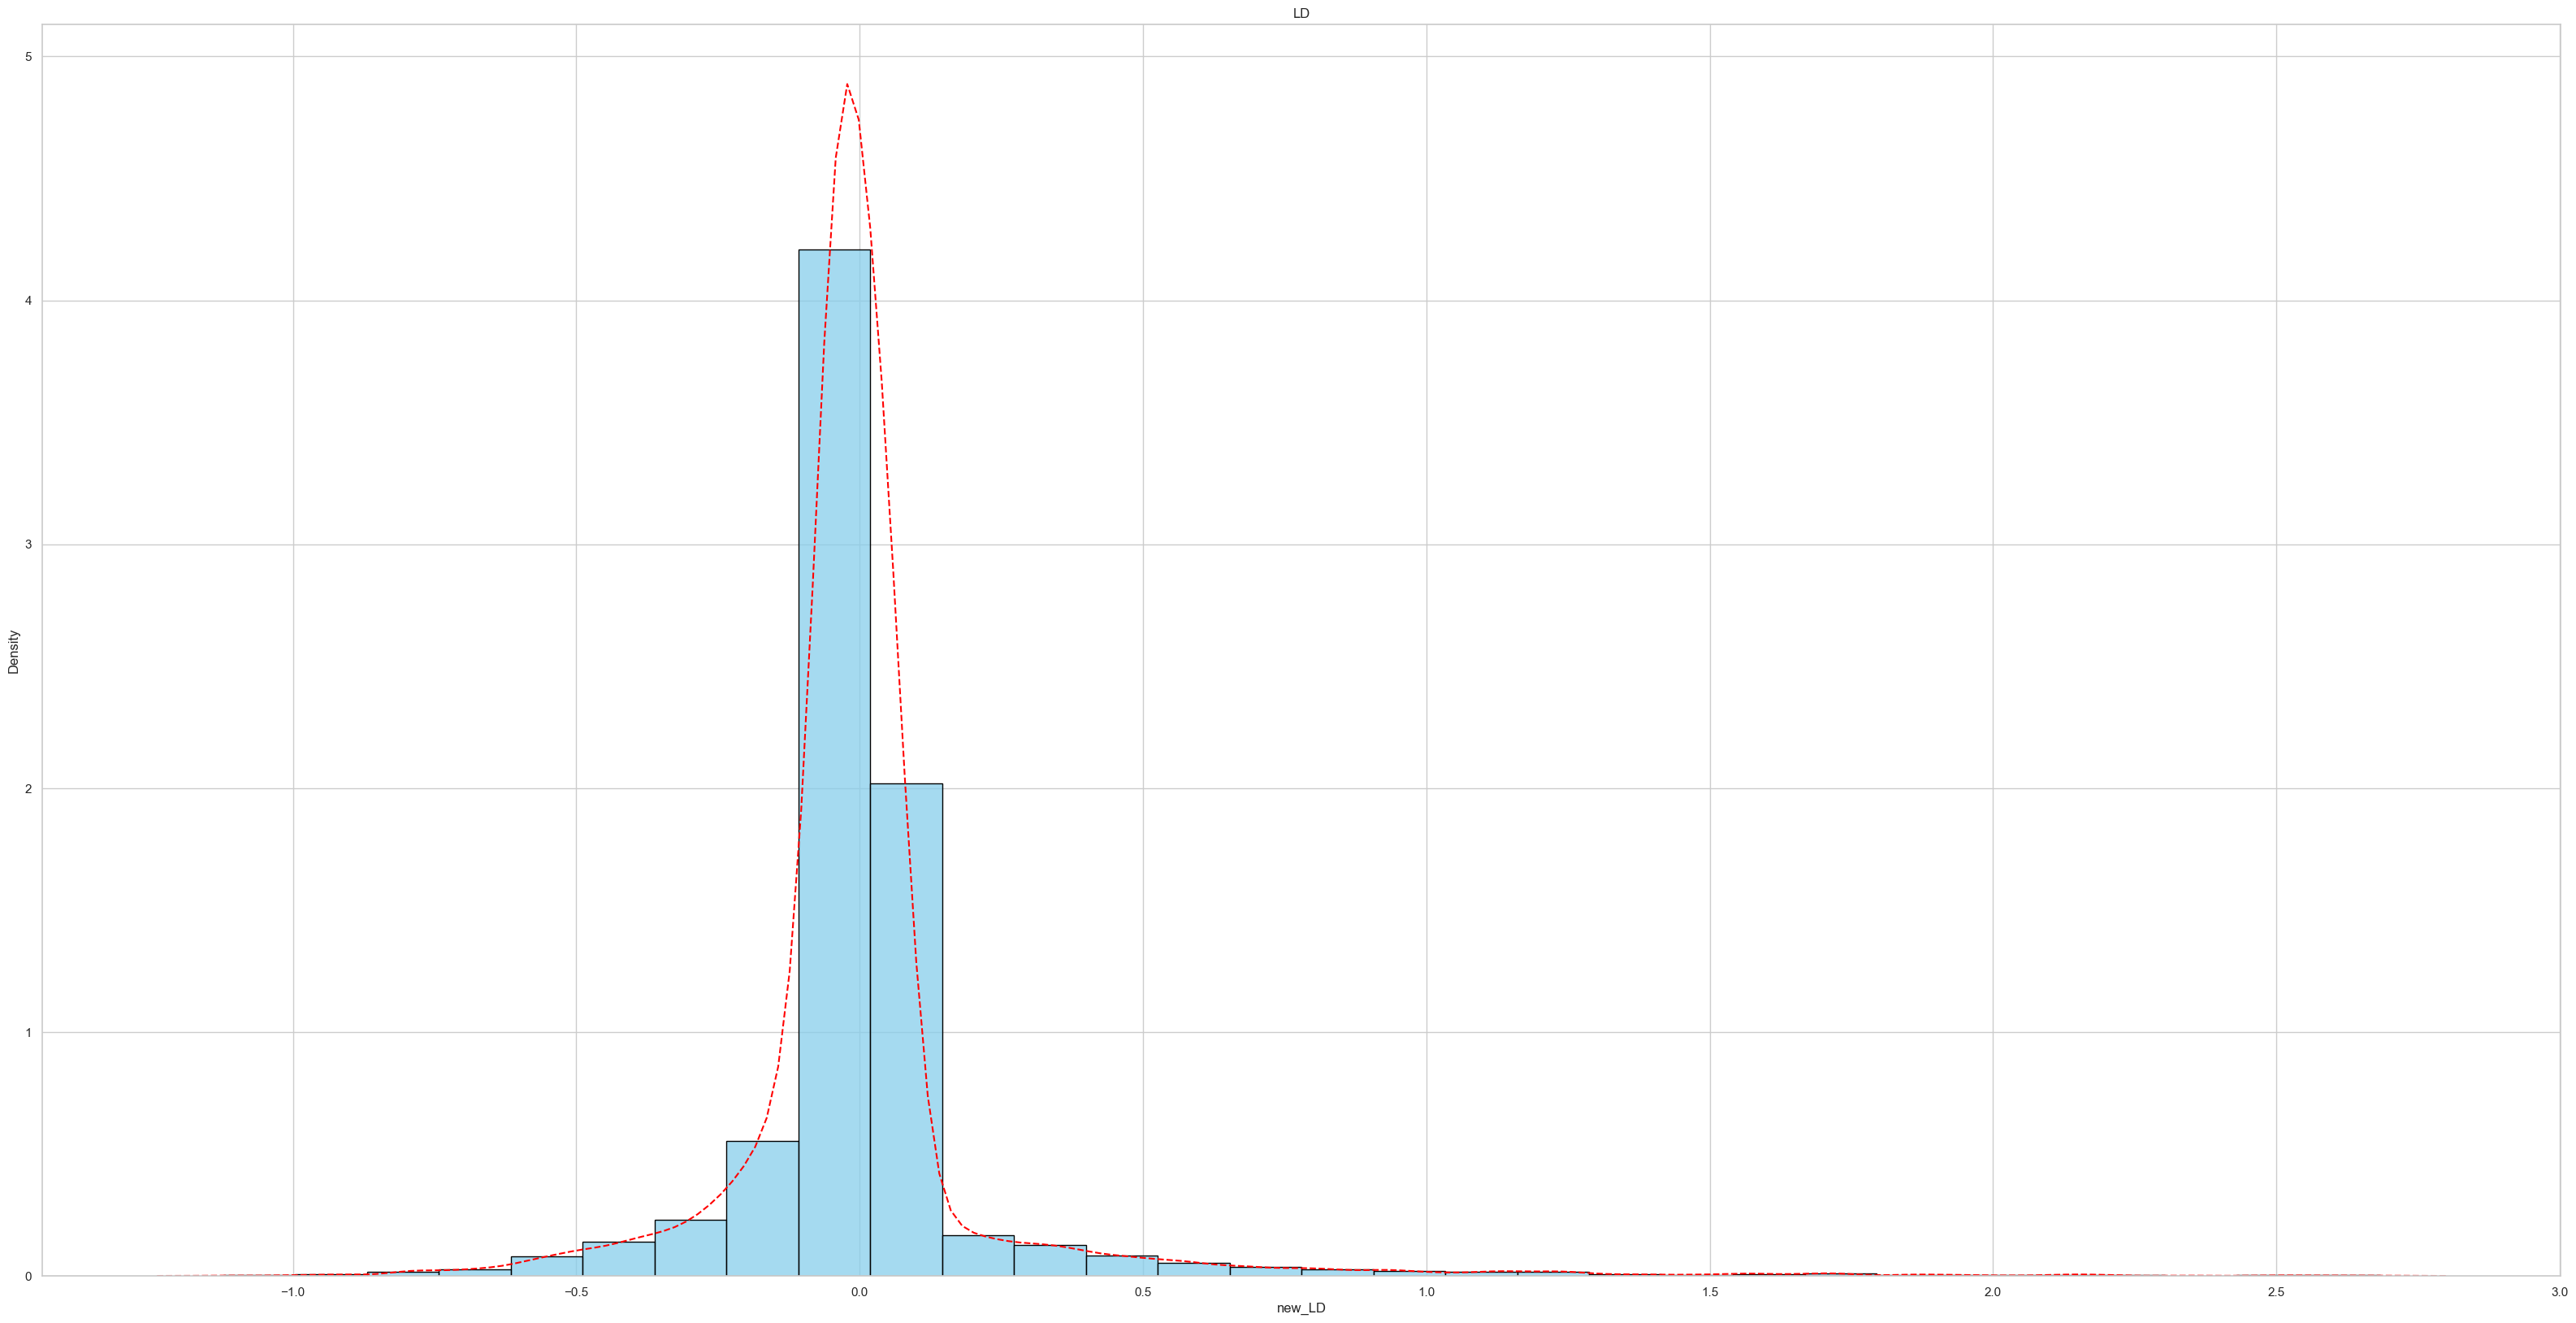

In [232]:
sns.histplot(merge_df['new_LD'], kde=False, color='skyblue', edgecolor='black', bins=30, stat='density')
sns.kdeplot(merge_df['new_LD'], color='red', linestyle='--')
plt.title('LD')
plt.ylabel('Density')
plt.show()

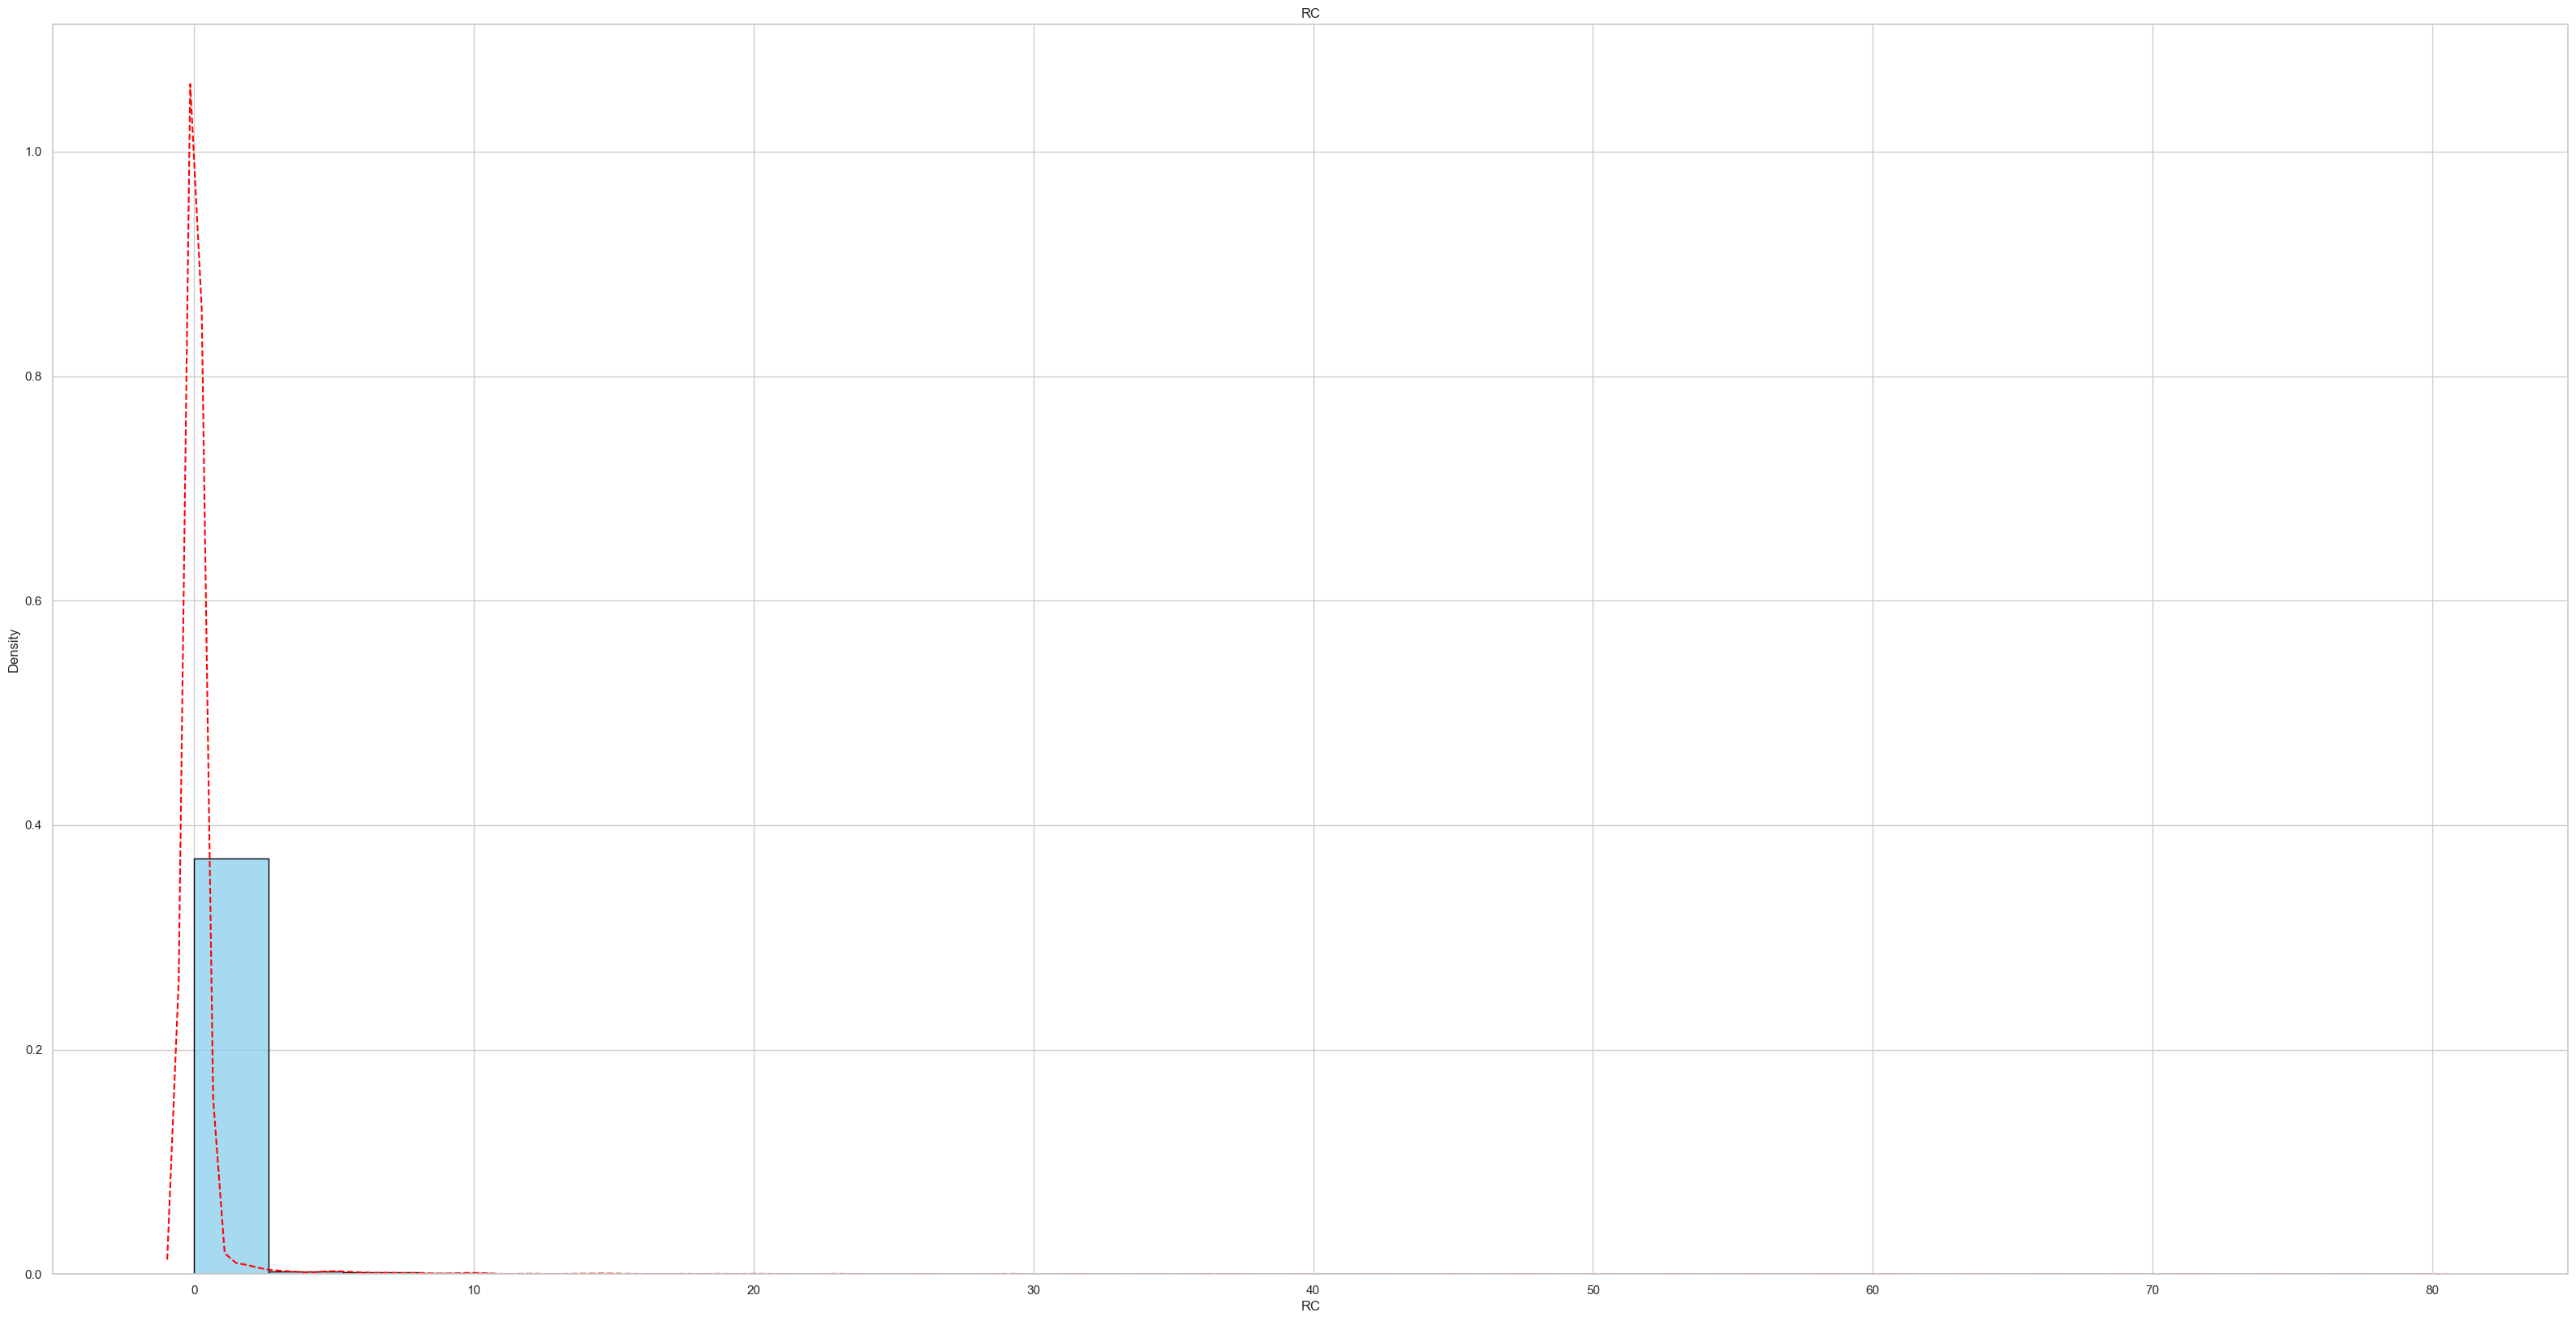

In [234]:
sns.histplot(merge_df['RC'], kde=False, color='skyblue', edgecolor='black', bins=30, stat='density')
sns.kdeplot(merge_df['RC'], color='red', linestyle='--')
plt.title('RC')
plt.ylabel('Density')
plt.show()

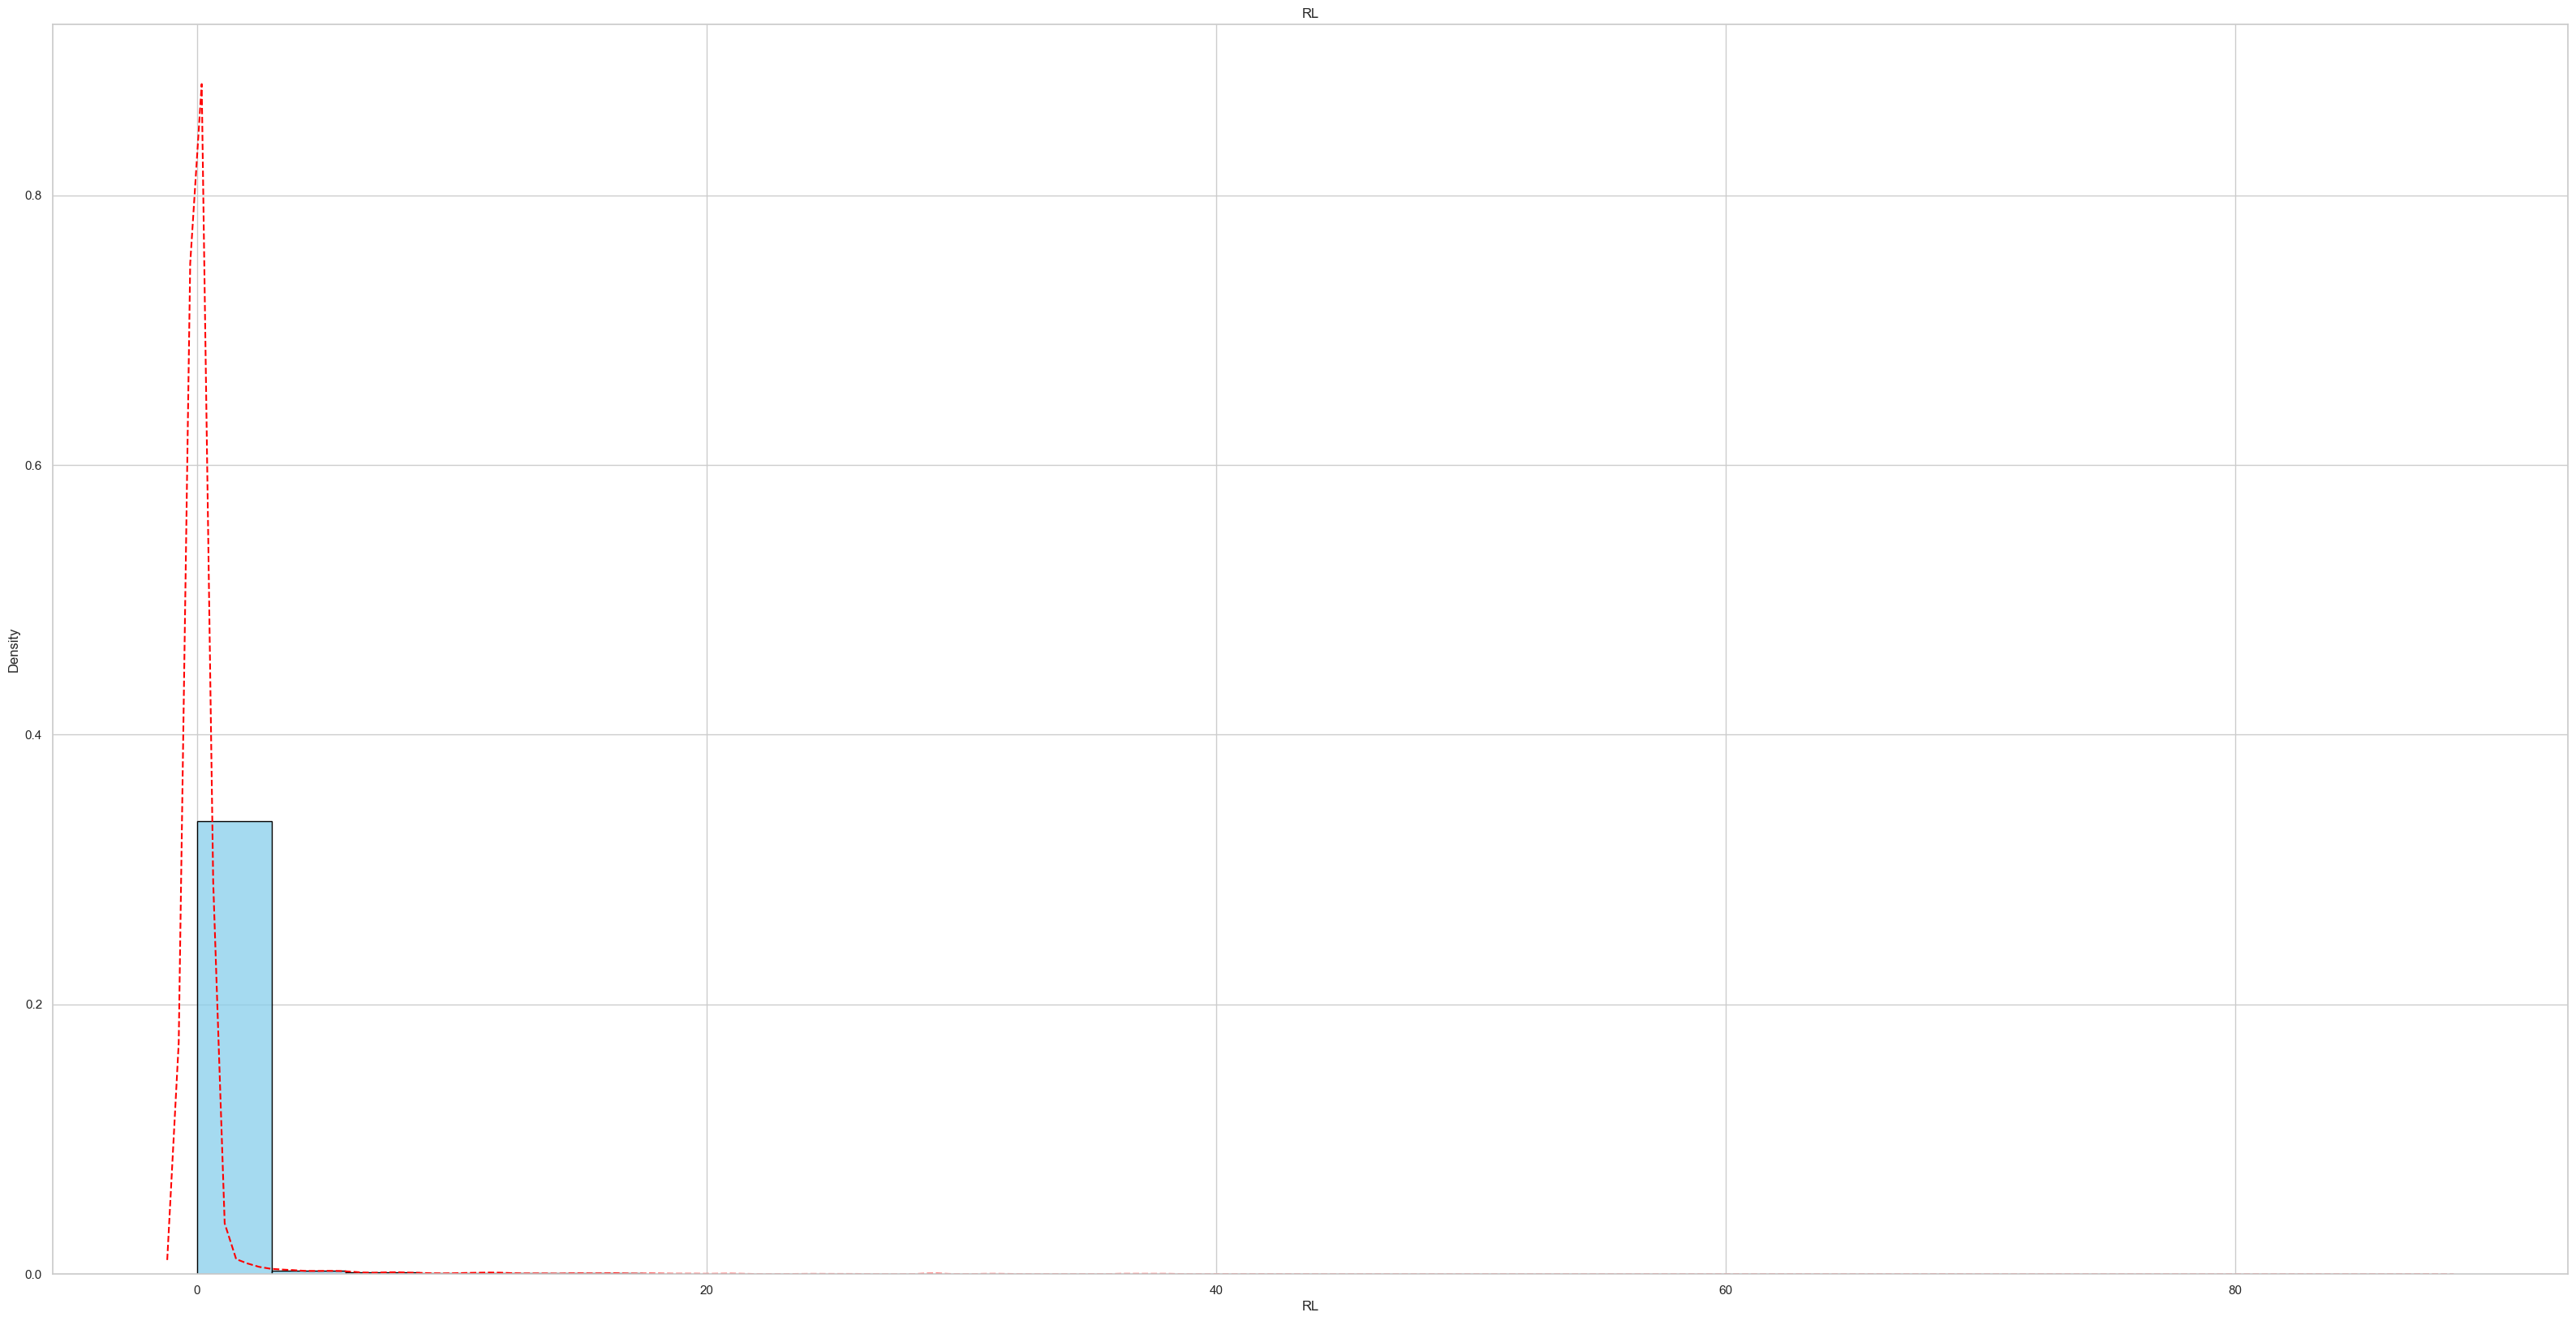

In [235]:
sns.histplot(merge_df['RL'], kde=False, color='skyblue', edgecolor='black', bins=30, stat='density')
sns.kdeplot(merge_df['RL'], color='red', linestyle='--')
plt.title('RL')
plt.ylabel('Density')
plt.show()

# Scaling

In [236]:
from sklearn.preprocessing import StandardScaler

x_train_reshaped = x_train.reshape(-1, x_train.shape[-1])
x_validation_reshaped = x_validation.reshape(-1, x_validation.shape[-1])
x_test_reshaped = x_test.reshape(-1, x_test.shape[-1])

x_scaler = StandardScaler()
x_scaler.fit(x_train_reshaped)

x_train_scaled = x_scaler.transform(x_train_reshaped).reshape(x_train.shape)
x_validation_scaled = x_scaler.transform(x_validation_reshaped).reshape(x_validation.shape)
x_test_scaled = x_scaler.transform(x_test_reshaped).reshape(x_test.shape)

y_train_reshaped = y_train
y_validation_reshaped = y_validation
y_test_reshaped = y_test

y_scaler = StandardScaler()
y_scaler.fit(y_train_reshaped)

y_train_scaled = y_scaler.transform(y_train_reshaped)
y_validation_scaled = y_scaler.transform(y_validation_reshaped)
y_test_scaled = y_scaler.transform(y_test_reshaped)

In [237]:
print('Data for train:', x_train_scaled.shape, y_train_scaled.shape)
print('Total days for train:', x_train_scaled.shape[0] / 24)
print('\nData for validation:', x_validation_scaled.shape, y_validation_scaled.shape)
print('Total days for validation:', x_validation_scaled.shape[0] / 24)
print('\nData for test:', x_test_scaled.shape, y_test_scaled.shape)
print('Total days for test:', x_test_scaled.shape[0] / 24)

Data for train: (5944, 5, 4) (5944, 5)
Total days for train: 247.66666666666666

Data for validation: (1776, 5, 4) (1776, 5)
Total days for validation: 74.0

Data for test: (858, 5, 4) (858, 5)
Total days for test: 35.75


In [238]:
model = Sequential()

model.add(LSTM(300, input_shape=(n_steps_in, 4)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(300, return_sequences=True))
model.add(Activation('relu'))
model.add(TimeDistributed(Dense(1)))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 300)               366000    
                                                                 
 repeat_vector_4 (RepeatVec  (None, 5, 300)            0         
 tor)                                                            
                                                                 
 lstm_9 (LSTM)               (None, 5, 300)            721200    
                                                                 
 activation_4 (Activation)   (None, 5, 300)            0         
                                                                 
 time_distributed_4 (TimeDi  (None, 5, 1)              301       
 stributed)                                                      
                                                                 
Total params: 1087501 (4.15 MB)
Trainable params: 1087

In [239]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [240]:
epoch = 50
model.compile(optimizer='adam', loss=root_mean_squared_error, metrics=root_mean_squared_error)
model.fit(x_train_scaled, y_train_scaled, epochs=epoch, batch_size=32,validation_data=(x_validation_scaled, y_validation_scaled), verbose=1)

Epoch 1/50


186/186 [==============================] - 5s 19ms/step - loss: 0.7607 - root_mean_squared_error: 0.7618 - val_loss: 0.7133 - val_root_mean_squared_error: 0.7075
Epoch 2/50
186/186 [==============================] - 3s 18ms/step - loss: 0.7566 - root_mean_squared_error: 0.7562 - val_loss: 0.7062 - val_root_mean_squared_error: 0.7005
Epoch 3/50
186/186 [==============================] - 3s 16ms/step - loss: 0.7266 - root_mean_squared_error: 0.7271 - val_loss: 0.7039 - val_root_mean_squared_error: 0.6985
Epoch 4/50
186/186 [==============================] - 3s 17ms/step - loss: 0.7398 - root_mean_squared_error: 0.7393 - val_loss: 0.7074 - val_root_mean_squared_error: 0.7016
Epoch 5/50
186/186 [==============================] - 3s 16ms/step - loss: 0.7346 - root_mean_squared_error: 0.7340 - val_loss: 0.7039 - val_root_mean_squared_error: 0.6981
Epoch 6/50
186/186 [==============================] - 3s 17ms/step - loss: 0.7287 - root_mean_squared_error: 0.7284 - val_loss: 0.6999 - val_root_

In [241]:
predictions = y_scaler.inverse_transform(model.predict_generator(x_test_scaled).reshape(-1,n_steps_out))
print(predictions.shape)

print(y_test.shape)

/var/folders/86/7gxks06s07xch2nsjg8bfzhh0000gn/T/ipykernel_4009/1410462172.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = y_scaler.inverse_transform(model.predict_generator(x_test_scaled).reshape(-1,n_steps_out))


(858, 5)
(858, 5)


In [242]:
predictions_train = y_scaler.inverse_transform(model.predict_generator(x_train_scaled).reshape(-1,n_steps_out))
print(predictions_train.shape)
print(y_train.shape)

/var/folders/86/7gxks06s07xch2nsjg8bfzhh0000gn/T/ipykernel_4009/1192994627.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions_train = y_scaler.inverse_transform(model.predict_generator(x_train_scaled).reshape(-1,n_steps_out))


(5944, 5)
(5944, 5)


In [243]:
real = y_test
real_train = y_train
predictions = pd.DataFrame(predictions)
predictions_for_train = pd.DataFrame(predictions_train)
real = pd.DataFrame(real)
real_train = pd.DataFrame(real_train)
print(predictions.shape)
print(real.shape)
print(predictions_for_train.shape)
print(real_train.shape)

(858, 5)
(858, 5)
(5944, 5)
(5944, 5)


In [244]:
real[0]

0     0.00
1     0.00
2     0.00
3     0.00
4     0.60
      ... 
853   0.00
854   0.00
855   0.00
856   0.00
857   0.00
Name: 0, Length: 858, dtype: float64

In [245]:
predictions[0]

0     -0.05
1     -0.02
2     -0.01
3      0.01
4      0.01
       ... 
853   -0.03
854   -0.01
855   -0.00
856    0.18
857   -0.01
Name: 0, Length: 858, dtype: float32

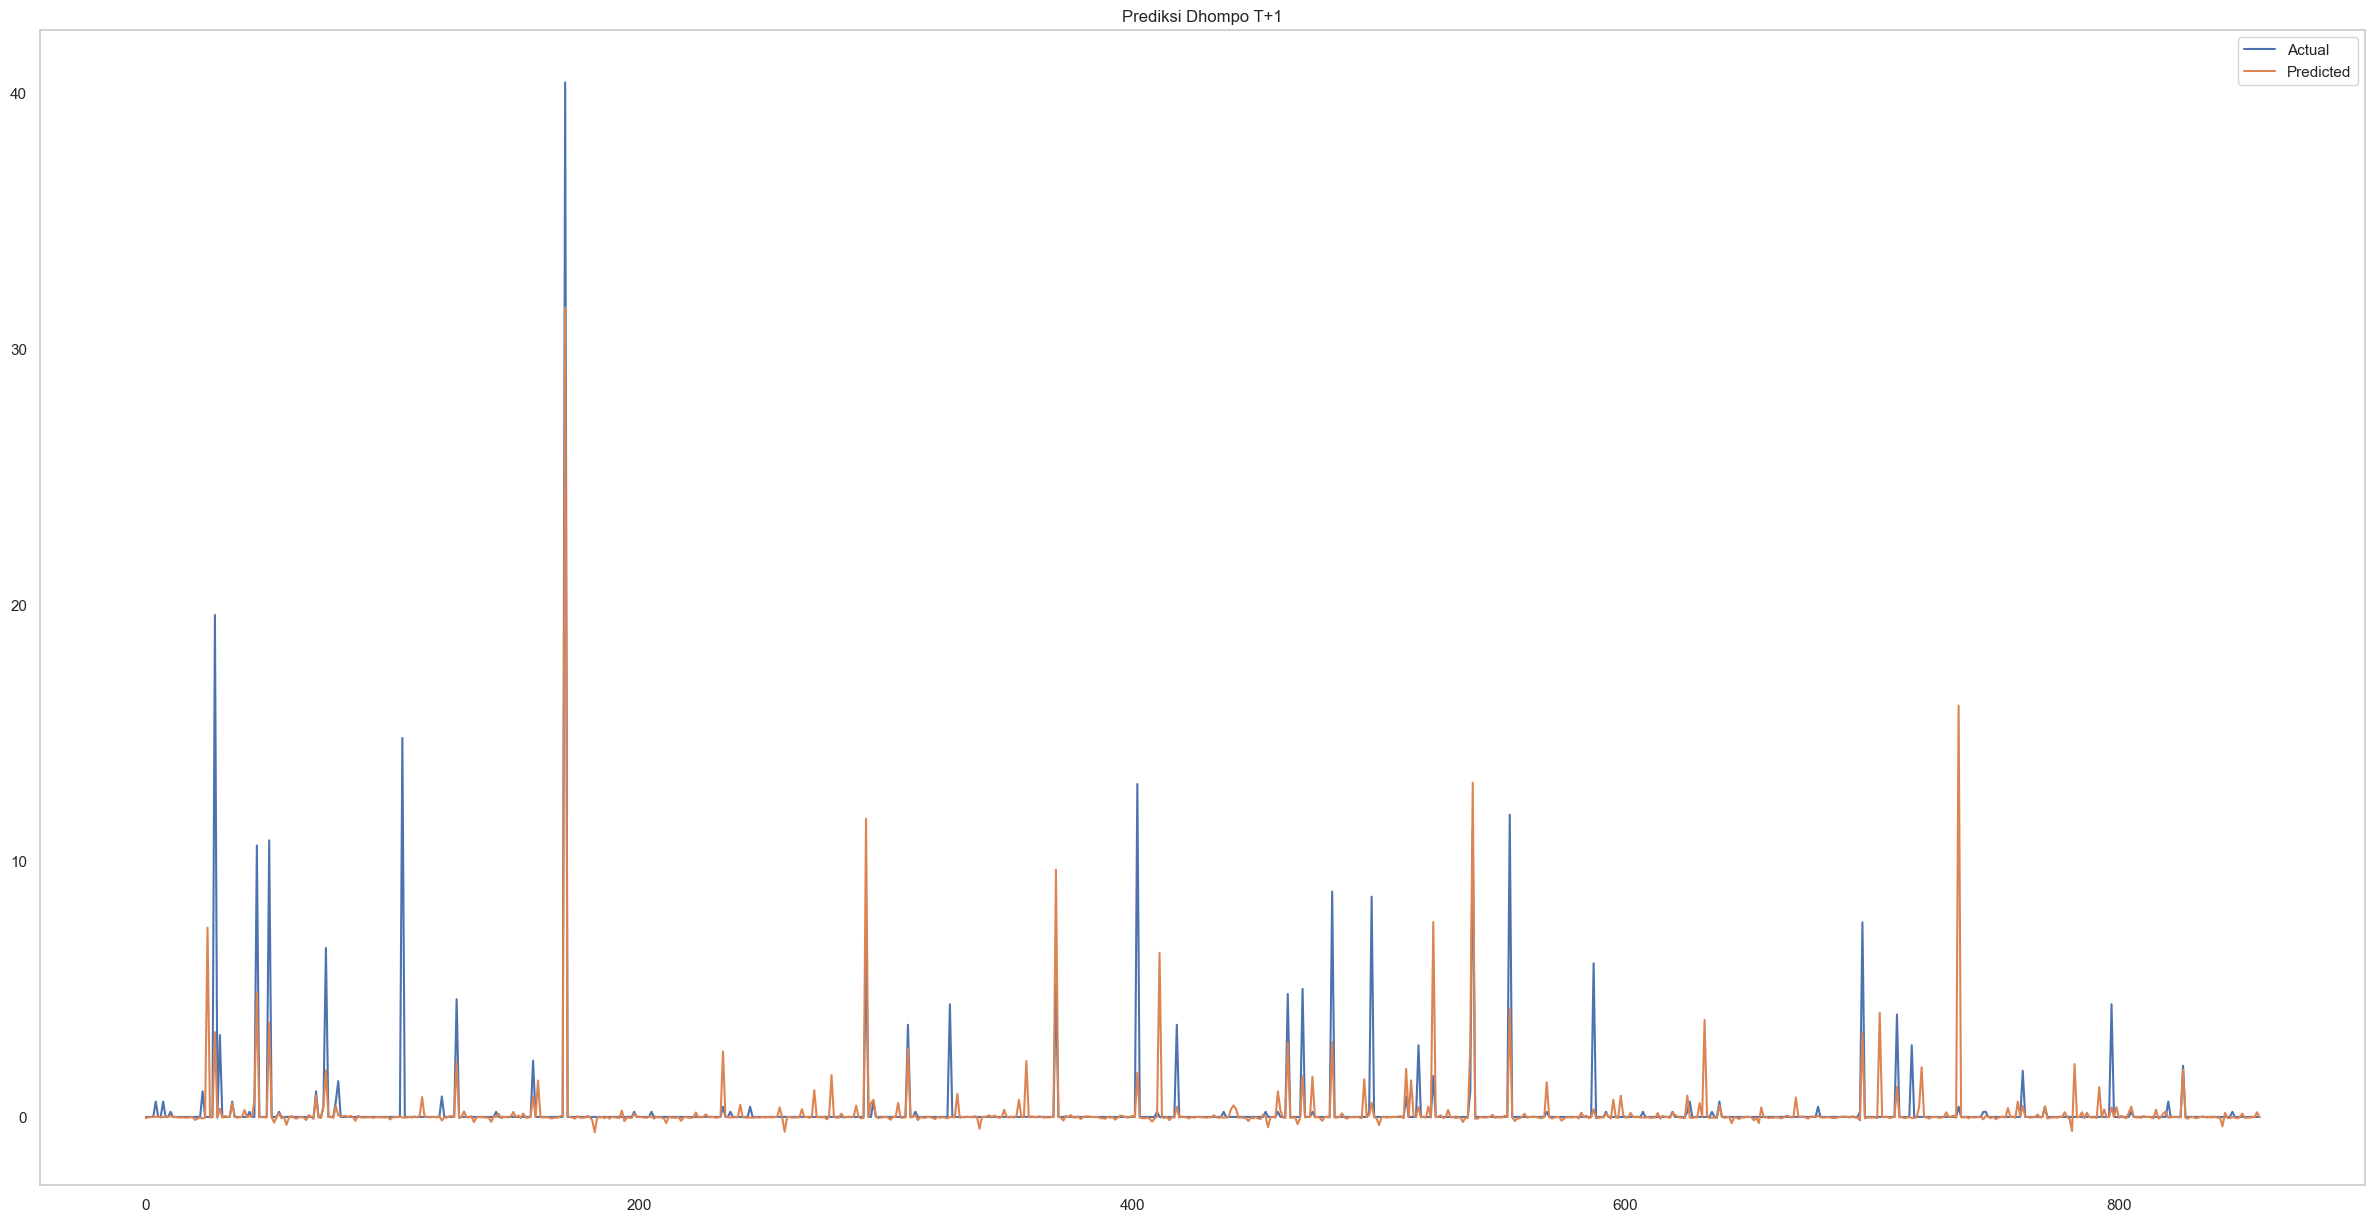

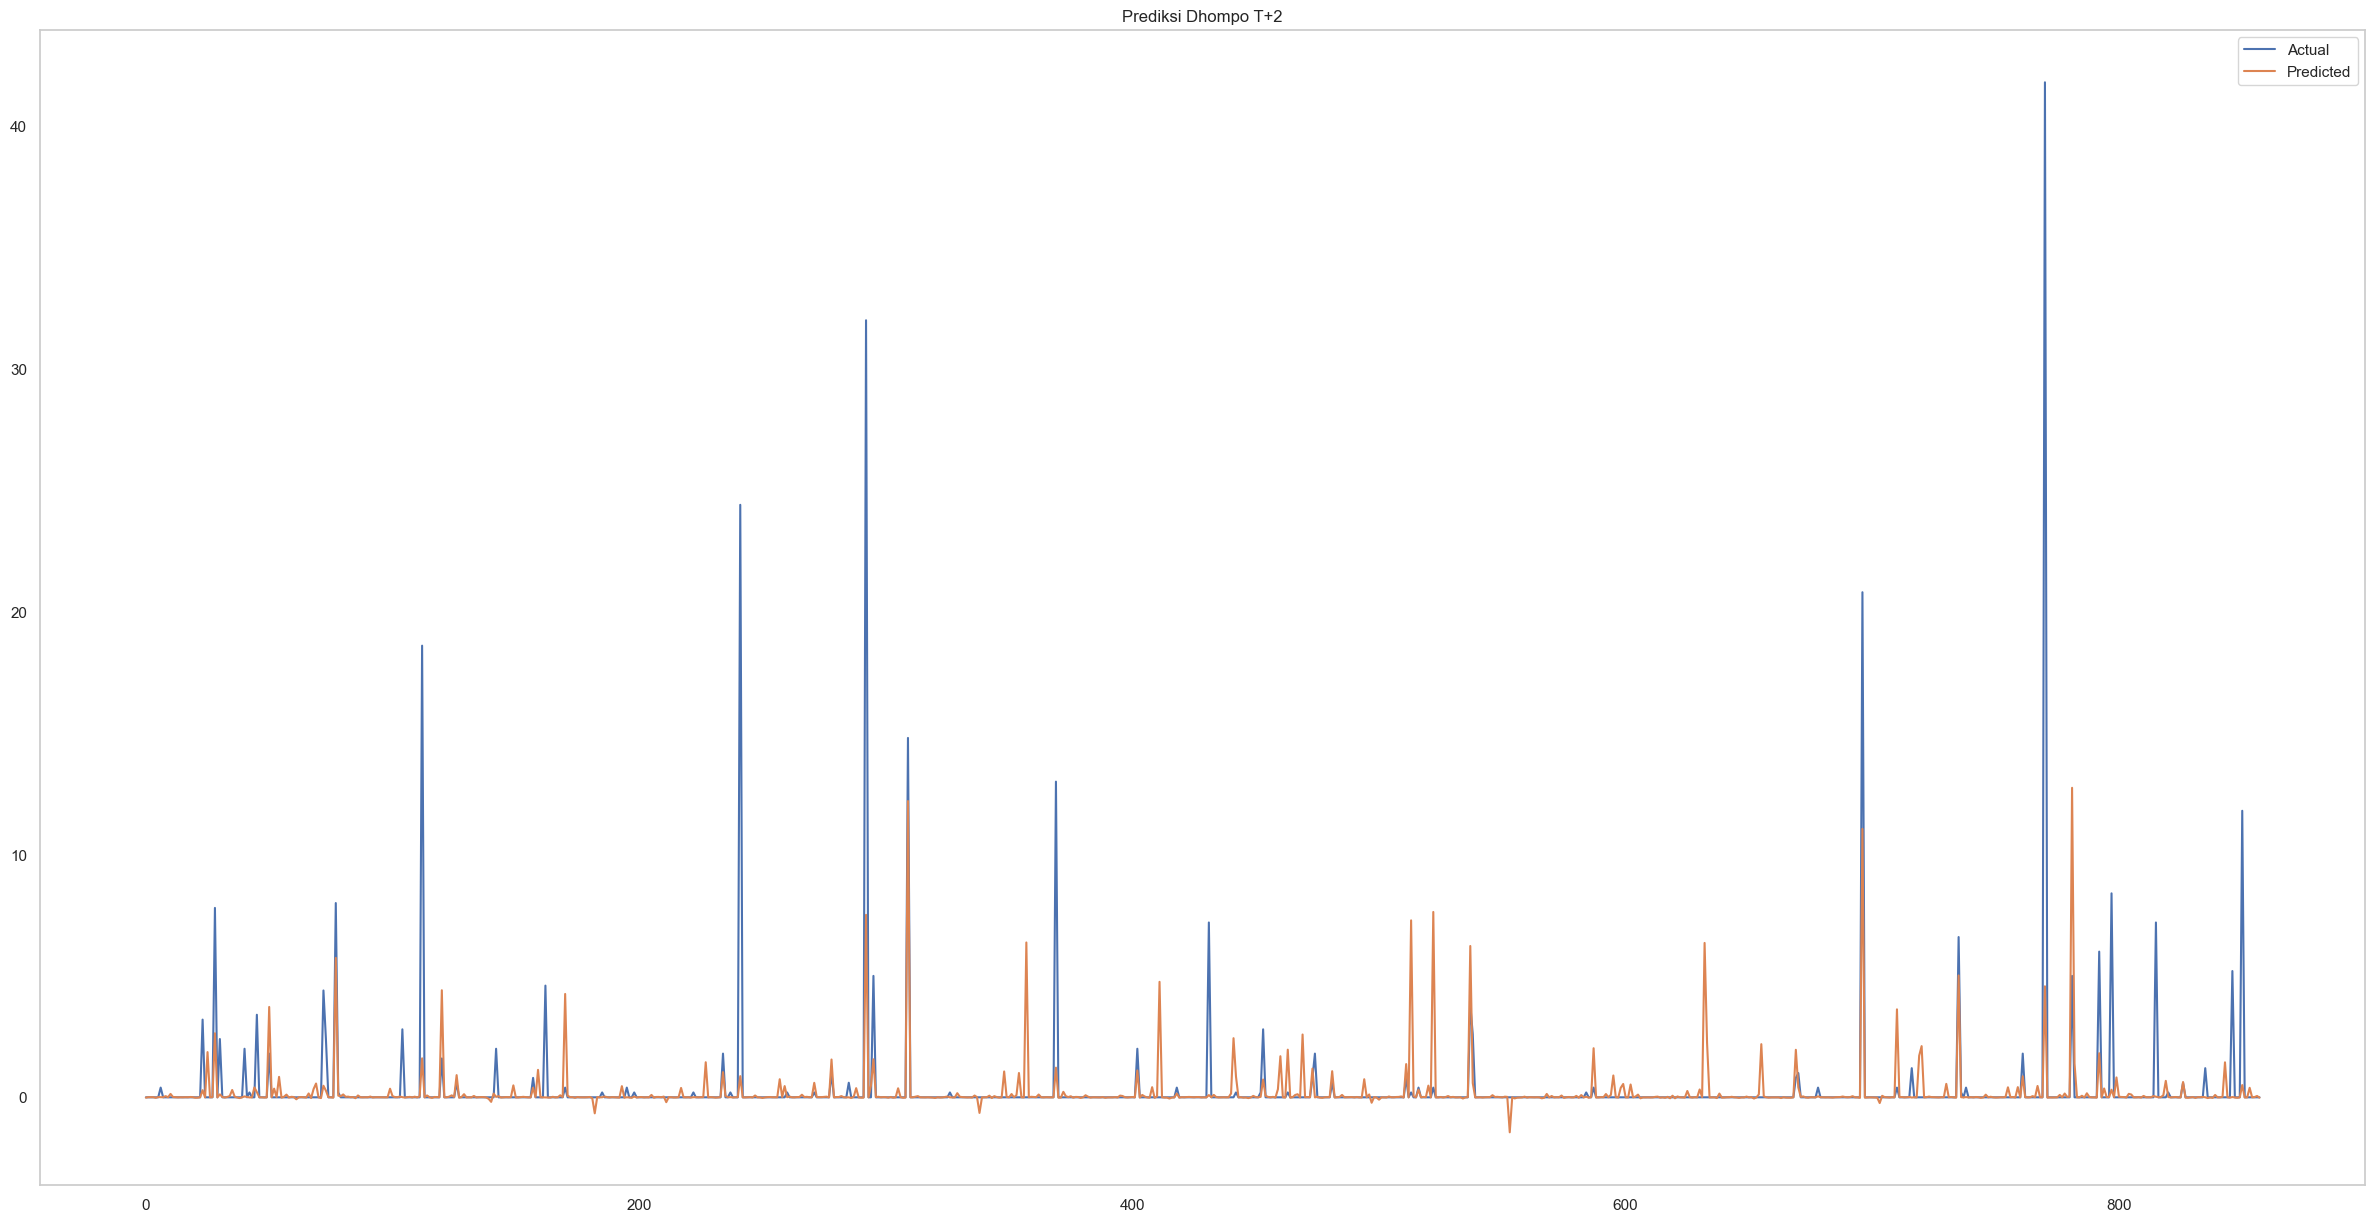

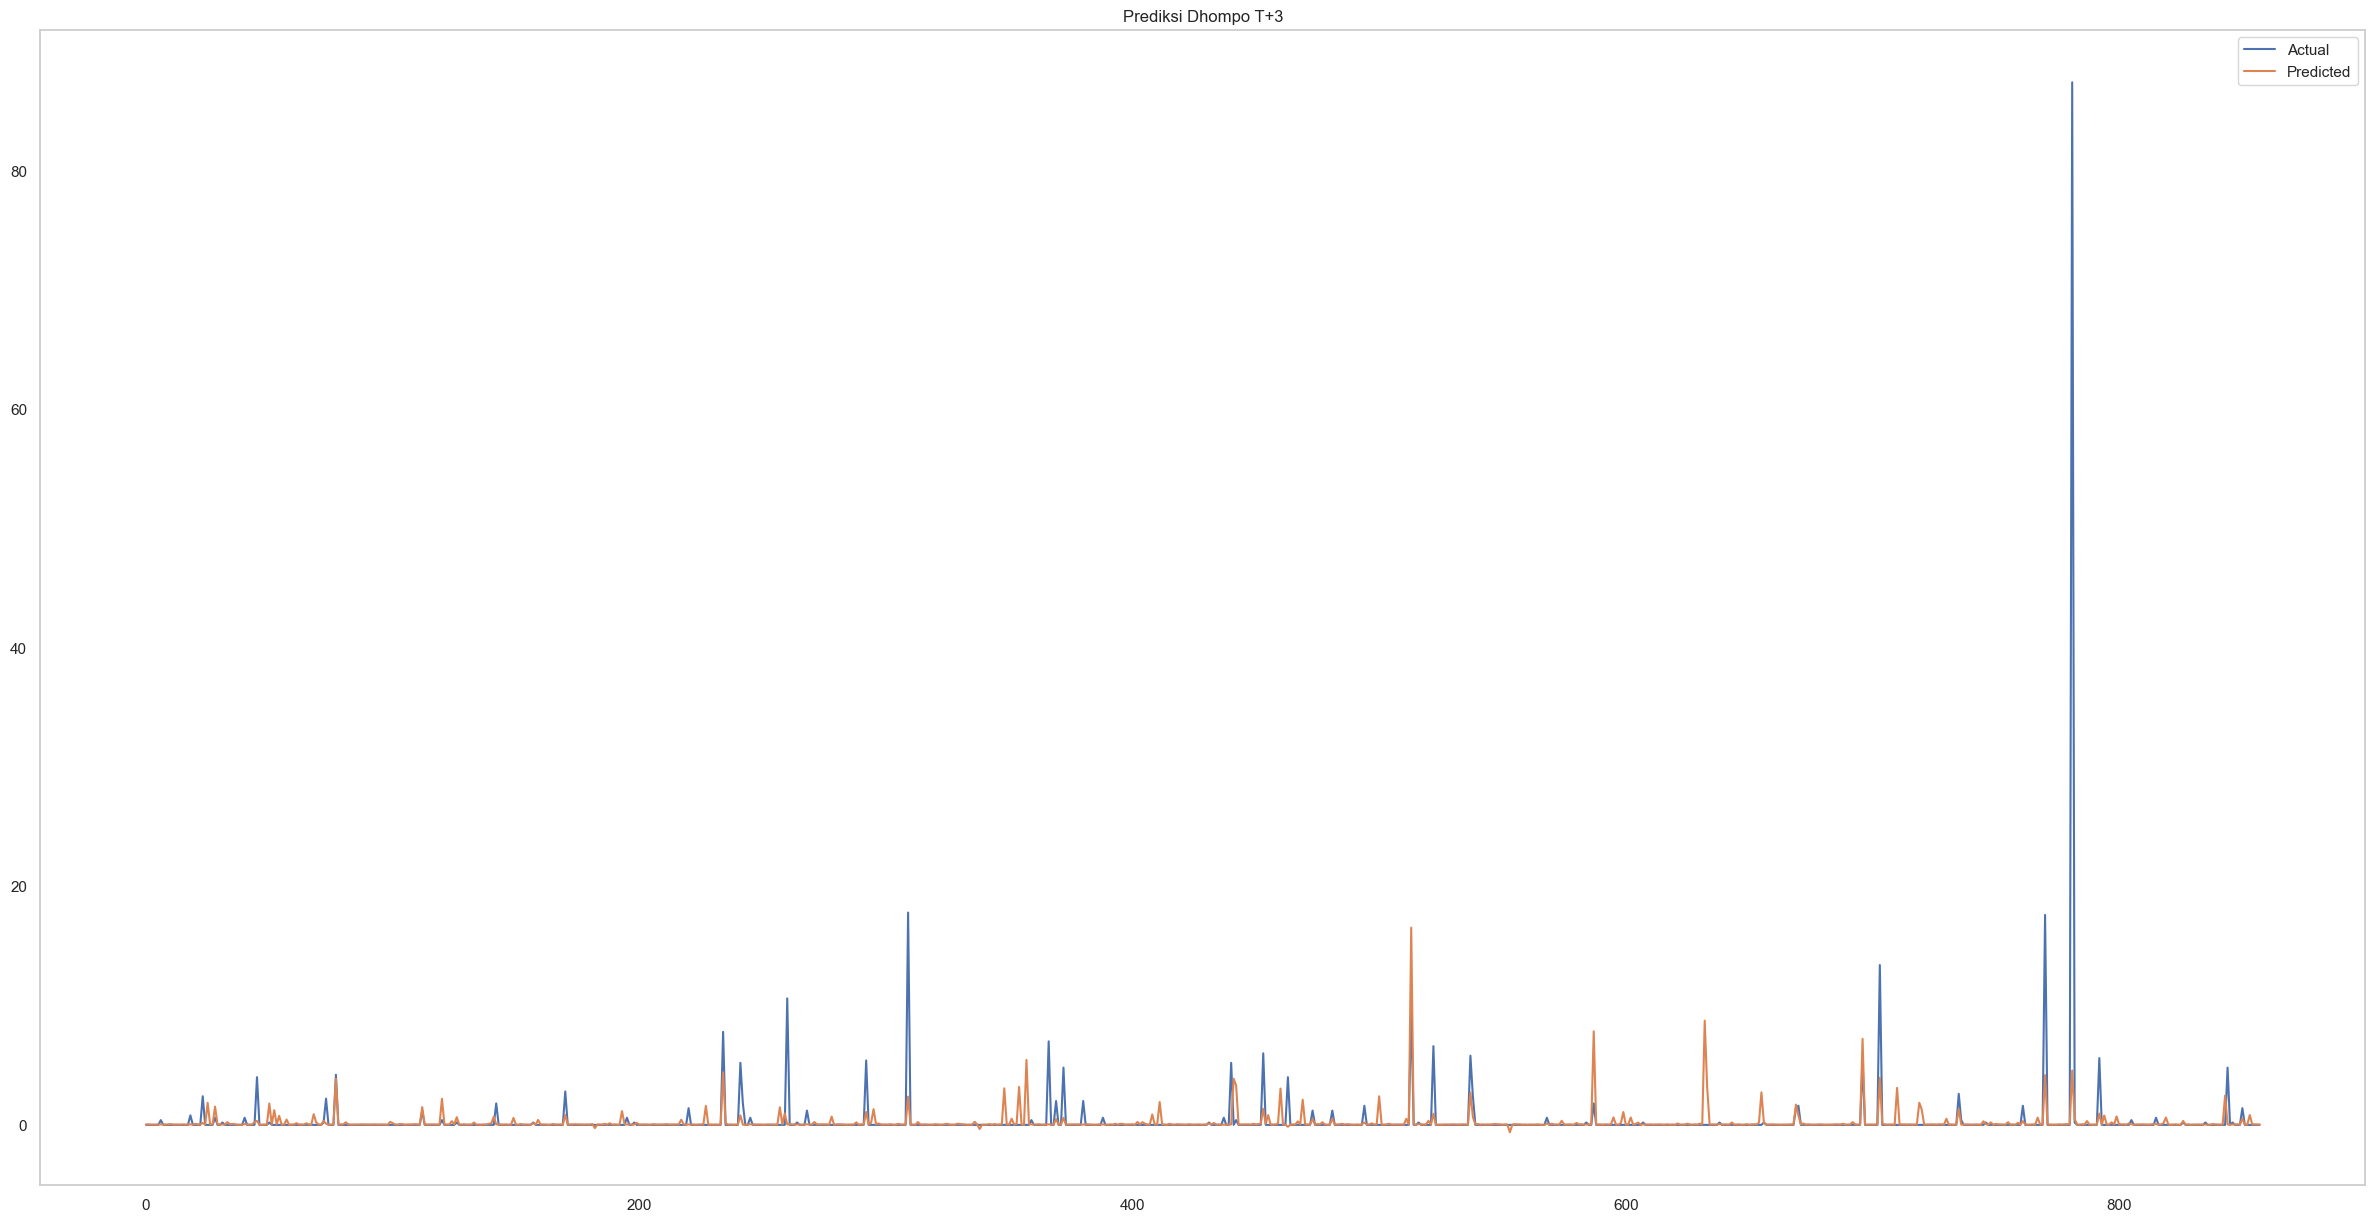

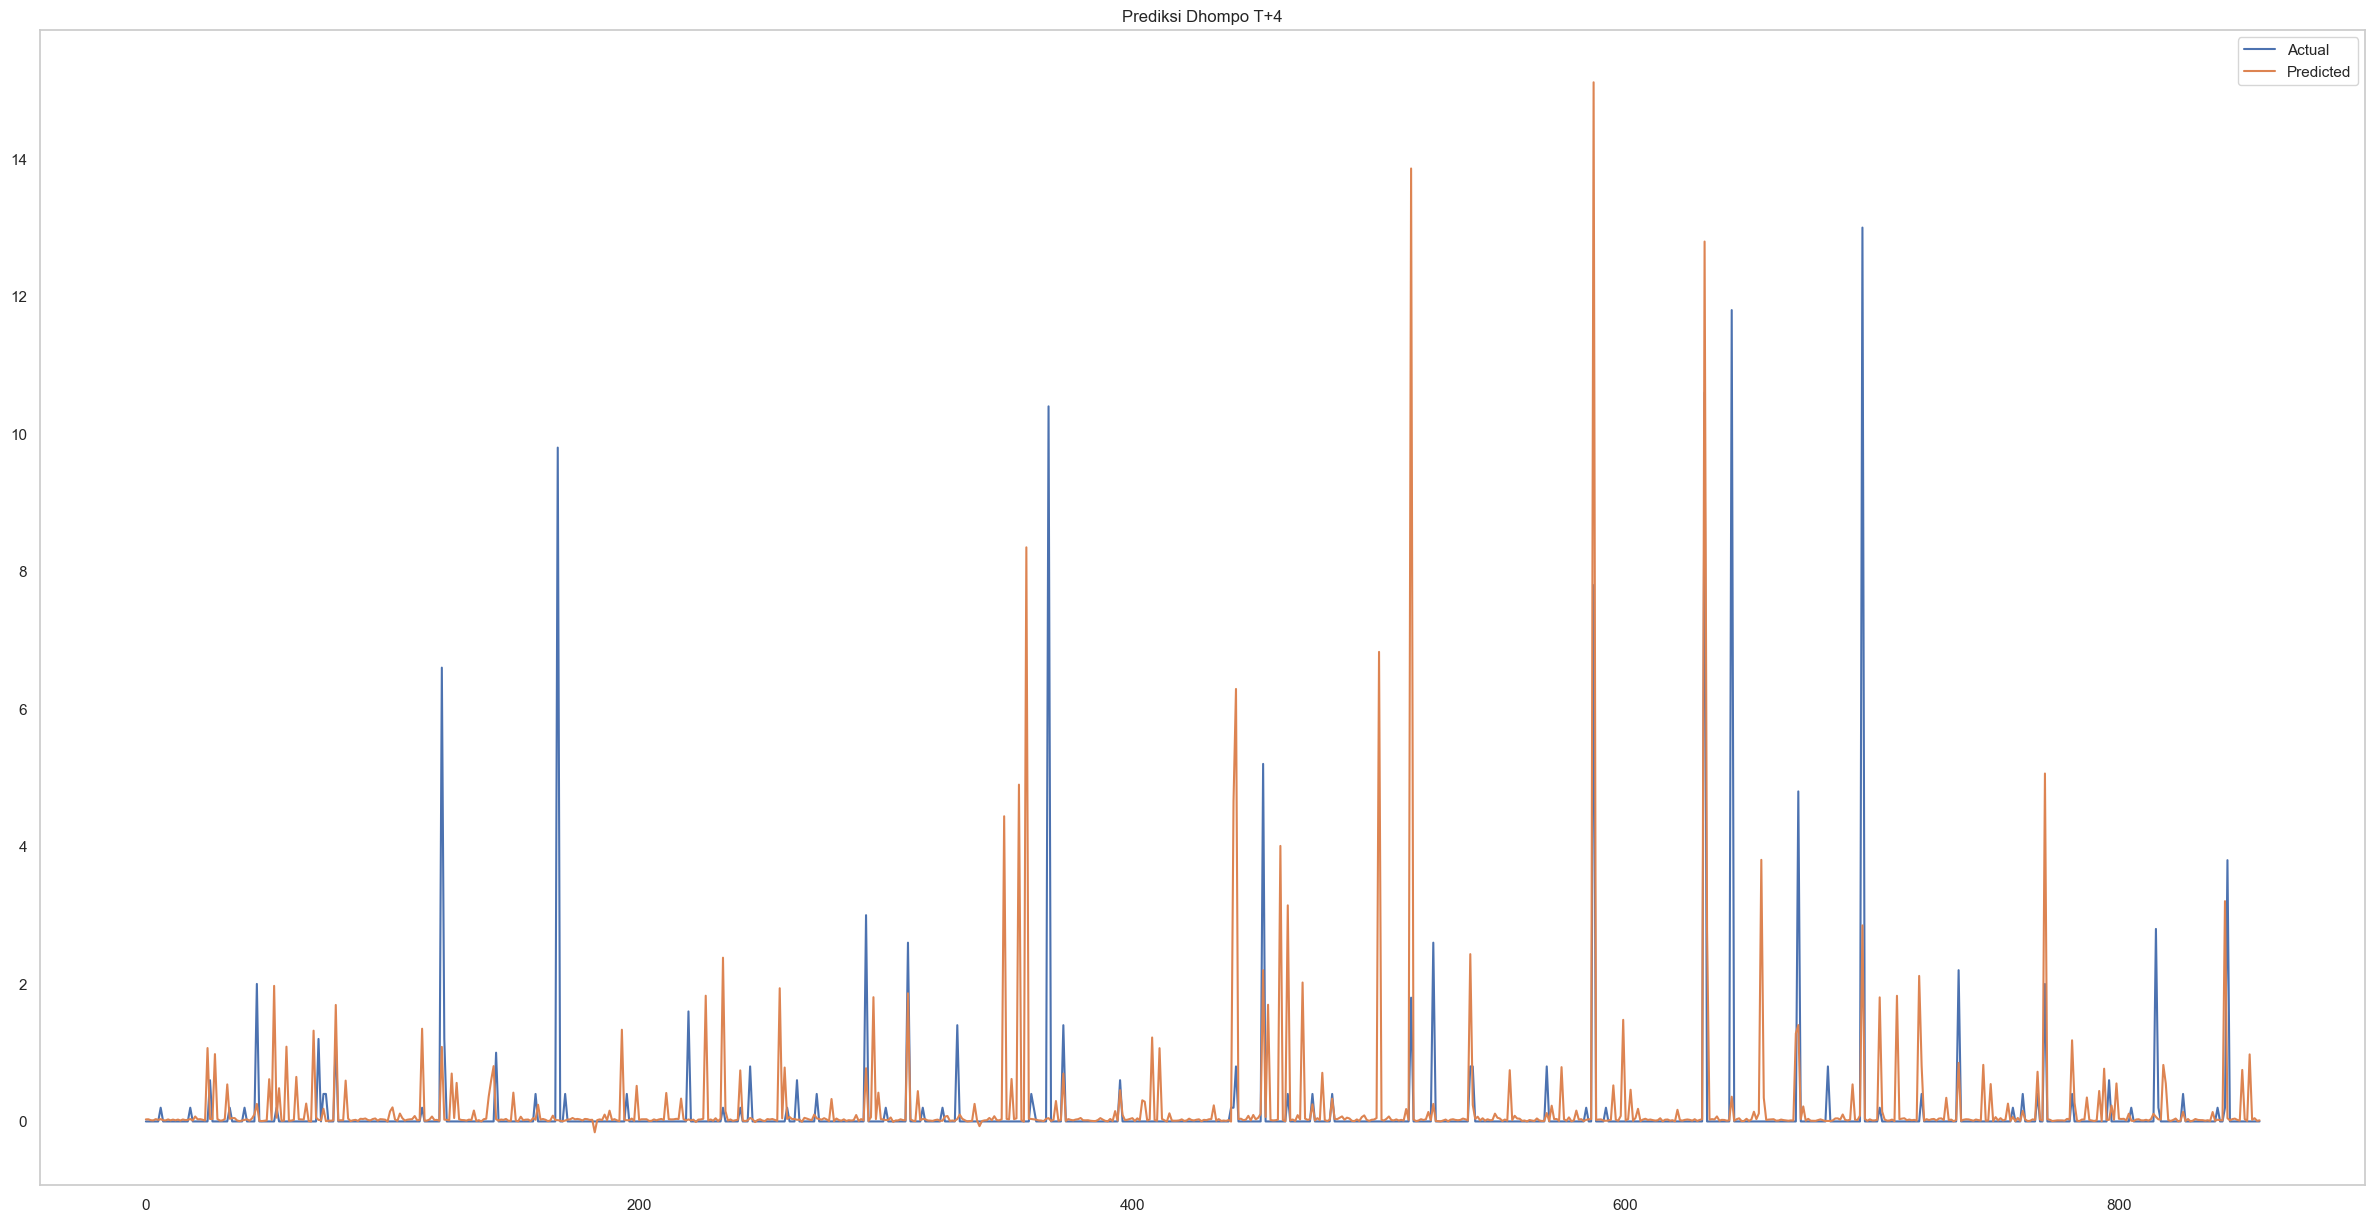

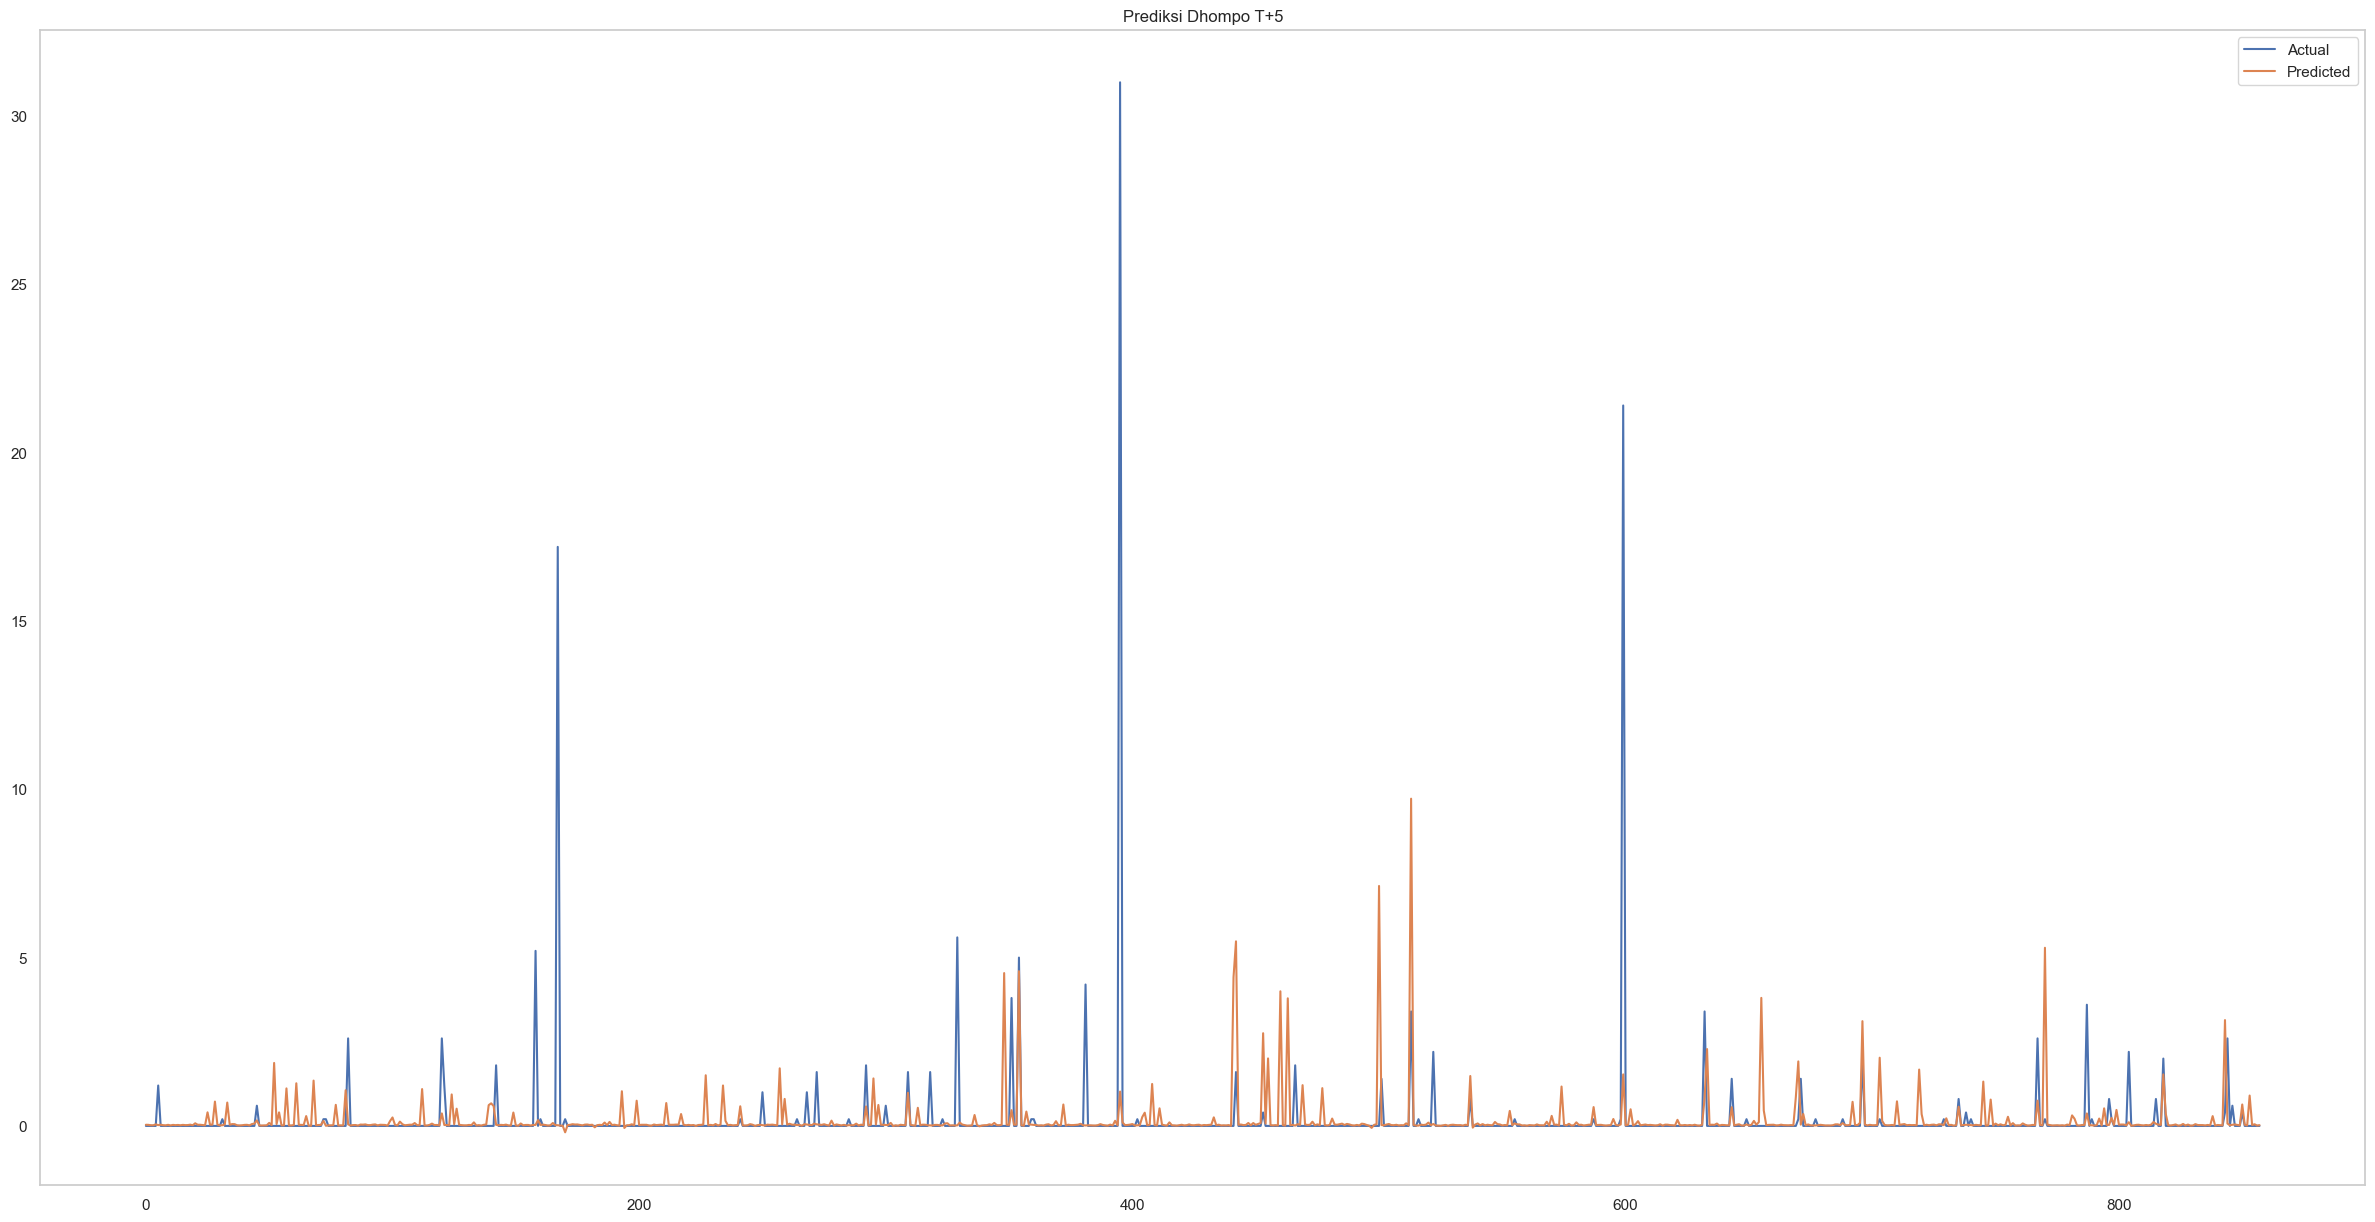

In [246]:
df_final = []
df_final_train = []

for i in range(1, n_steps_out+1):
    df_final.append(pd.DataFrame())
    df_final_train.append(pd.DataFrame())

for i in range(0,n_steps_out):
    df_final[i]['Tinggi Muka Air Dhompo'] = real[i]
    df_final[i]['Prediksi Tinggi Muka Air Dhompo'] = predictions[i]
    df_final_train[i]['Tinggi Muka Air Dhompo'] = real_train[i]
    df_final_train[i]['Prediksi Tinggi Muka Air Dhompo'] = predictions_for_train[i]

    mpl.rcParams['figure.figsize'] = (30, 15)
    mpl.rcParams['axes.grid'] = False
    ax = df_final[i][['Tinggi Muka Air Dhompo', 'Prediksi Tinggi Muka Air Dhompo']].plot()
    ax.legend(["Actual", "Predicted"]) 
    ax.set_title(f"Prediksi Dhompo T+{i+1}")

    plt.show()

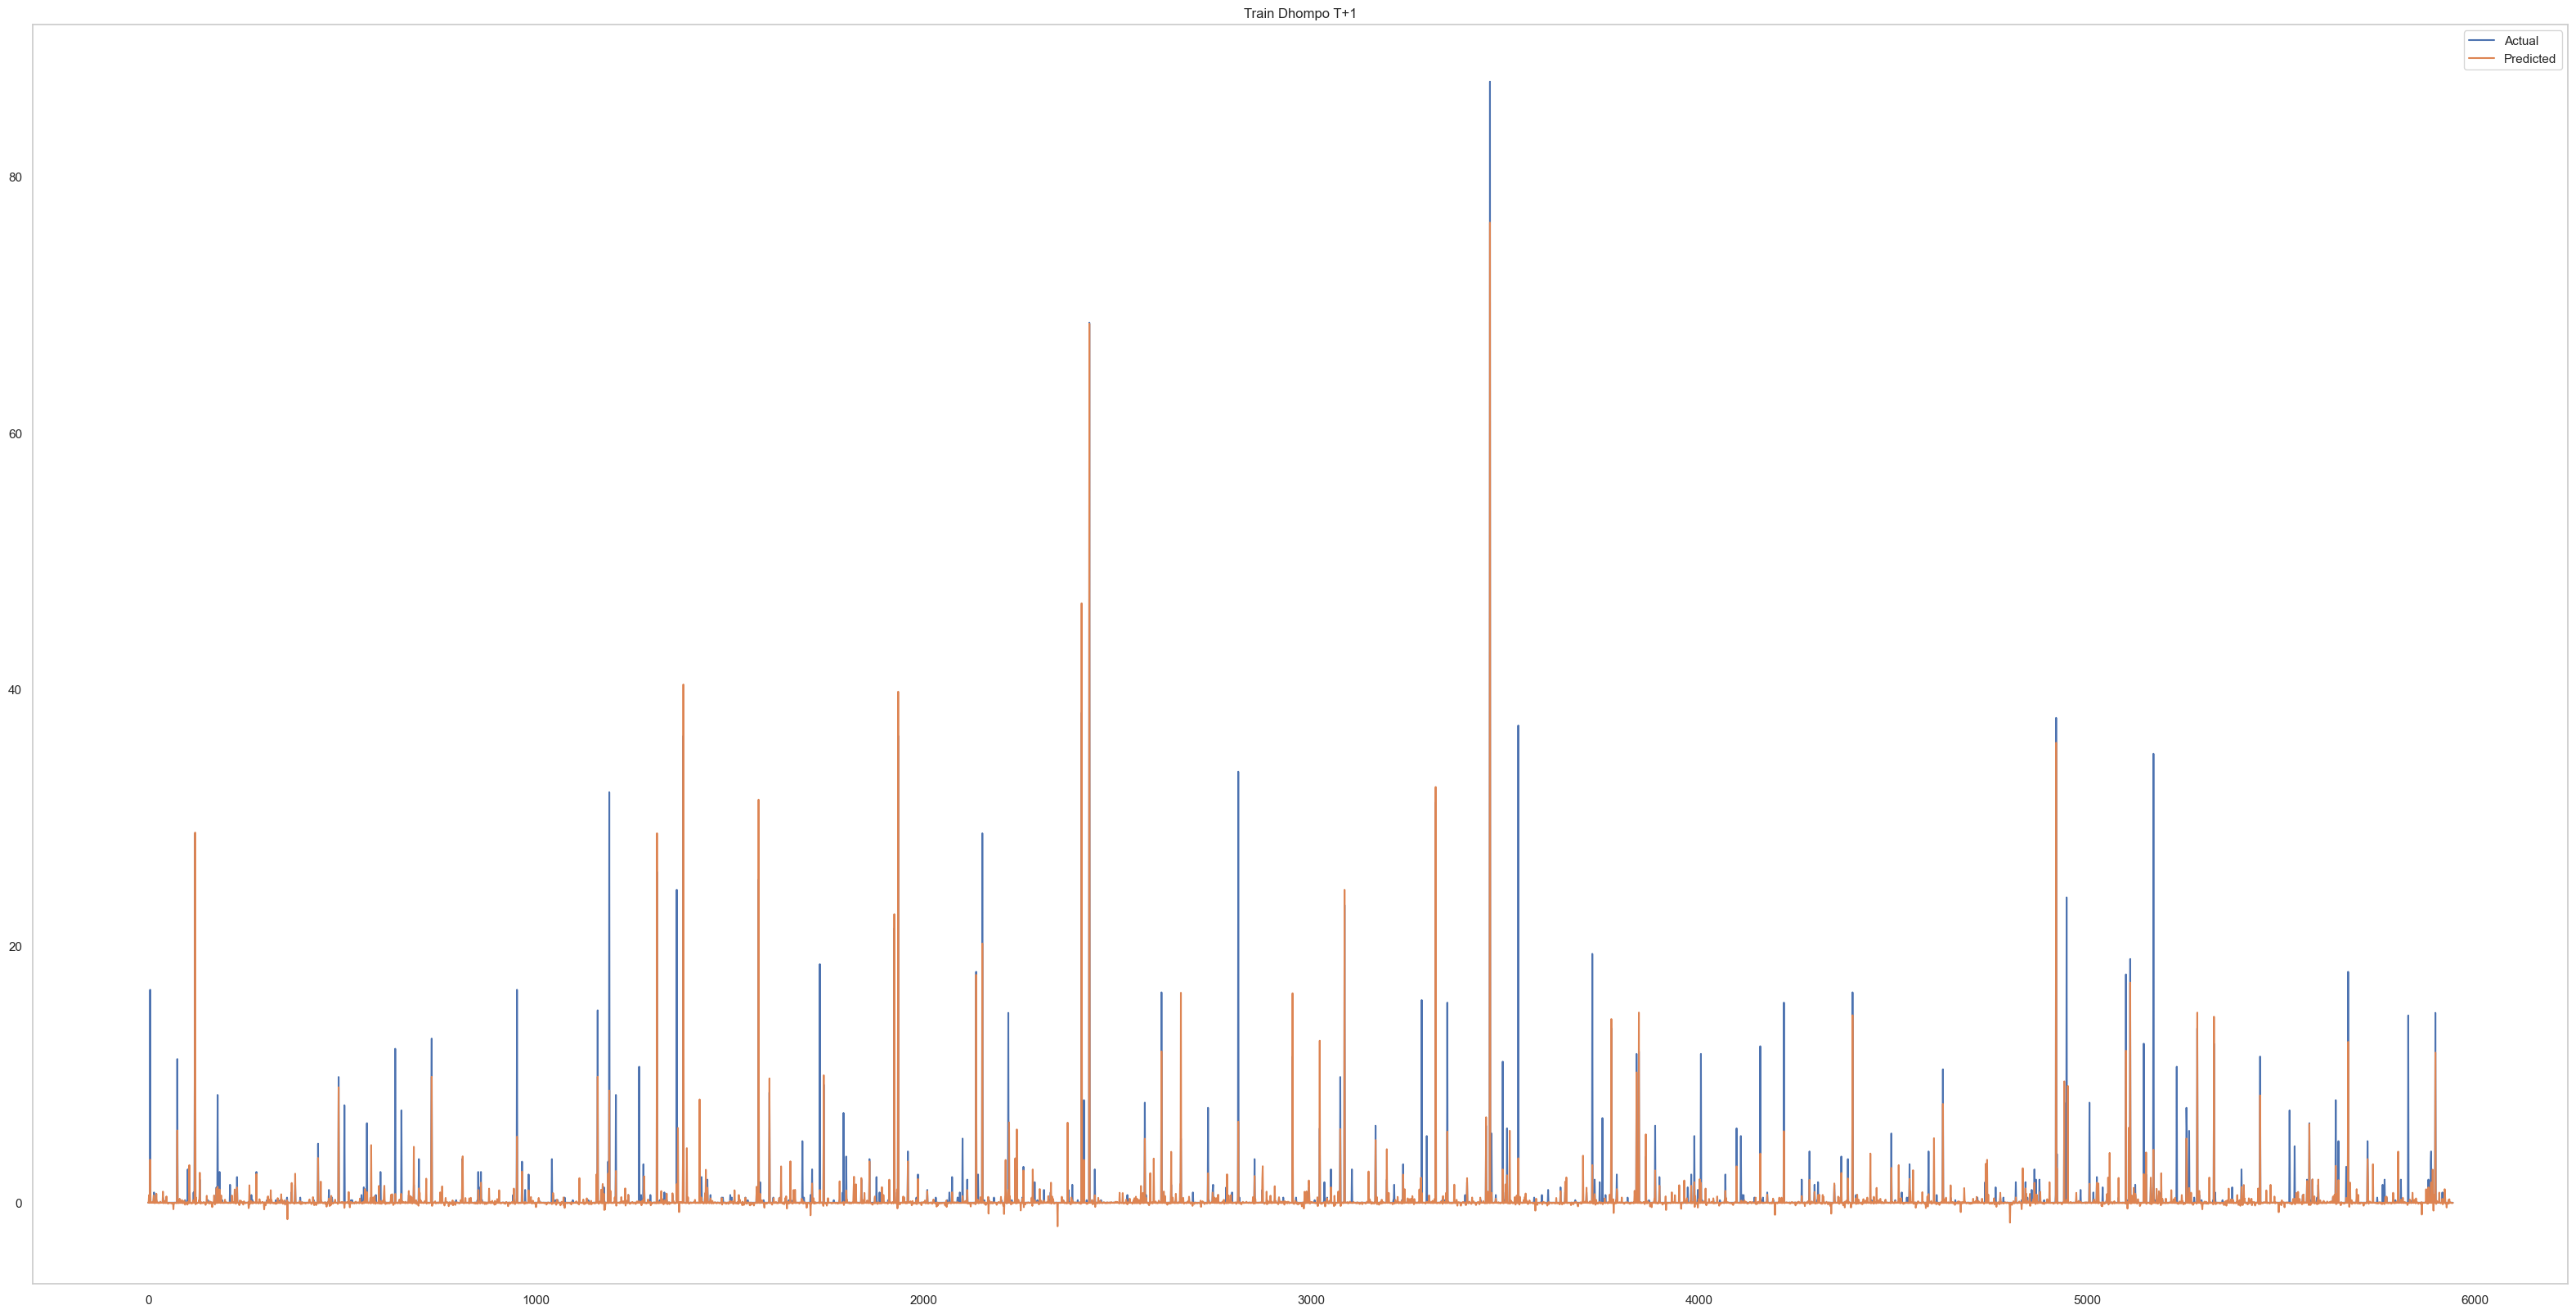

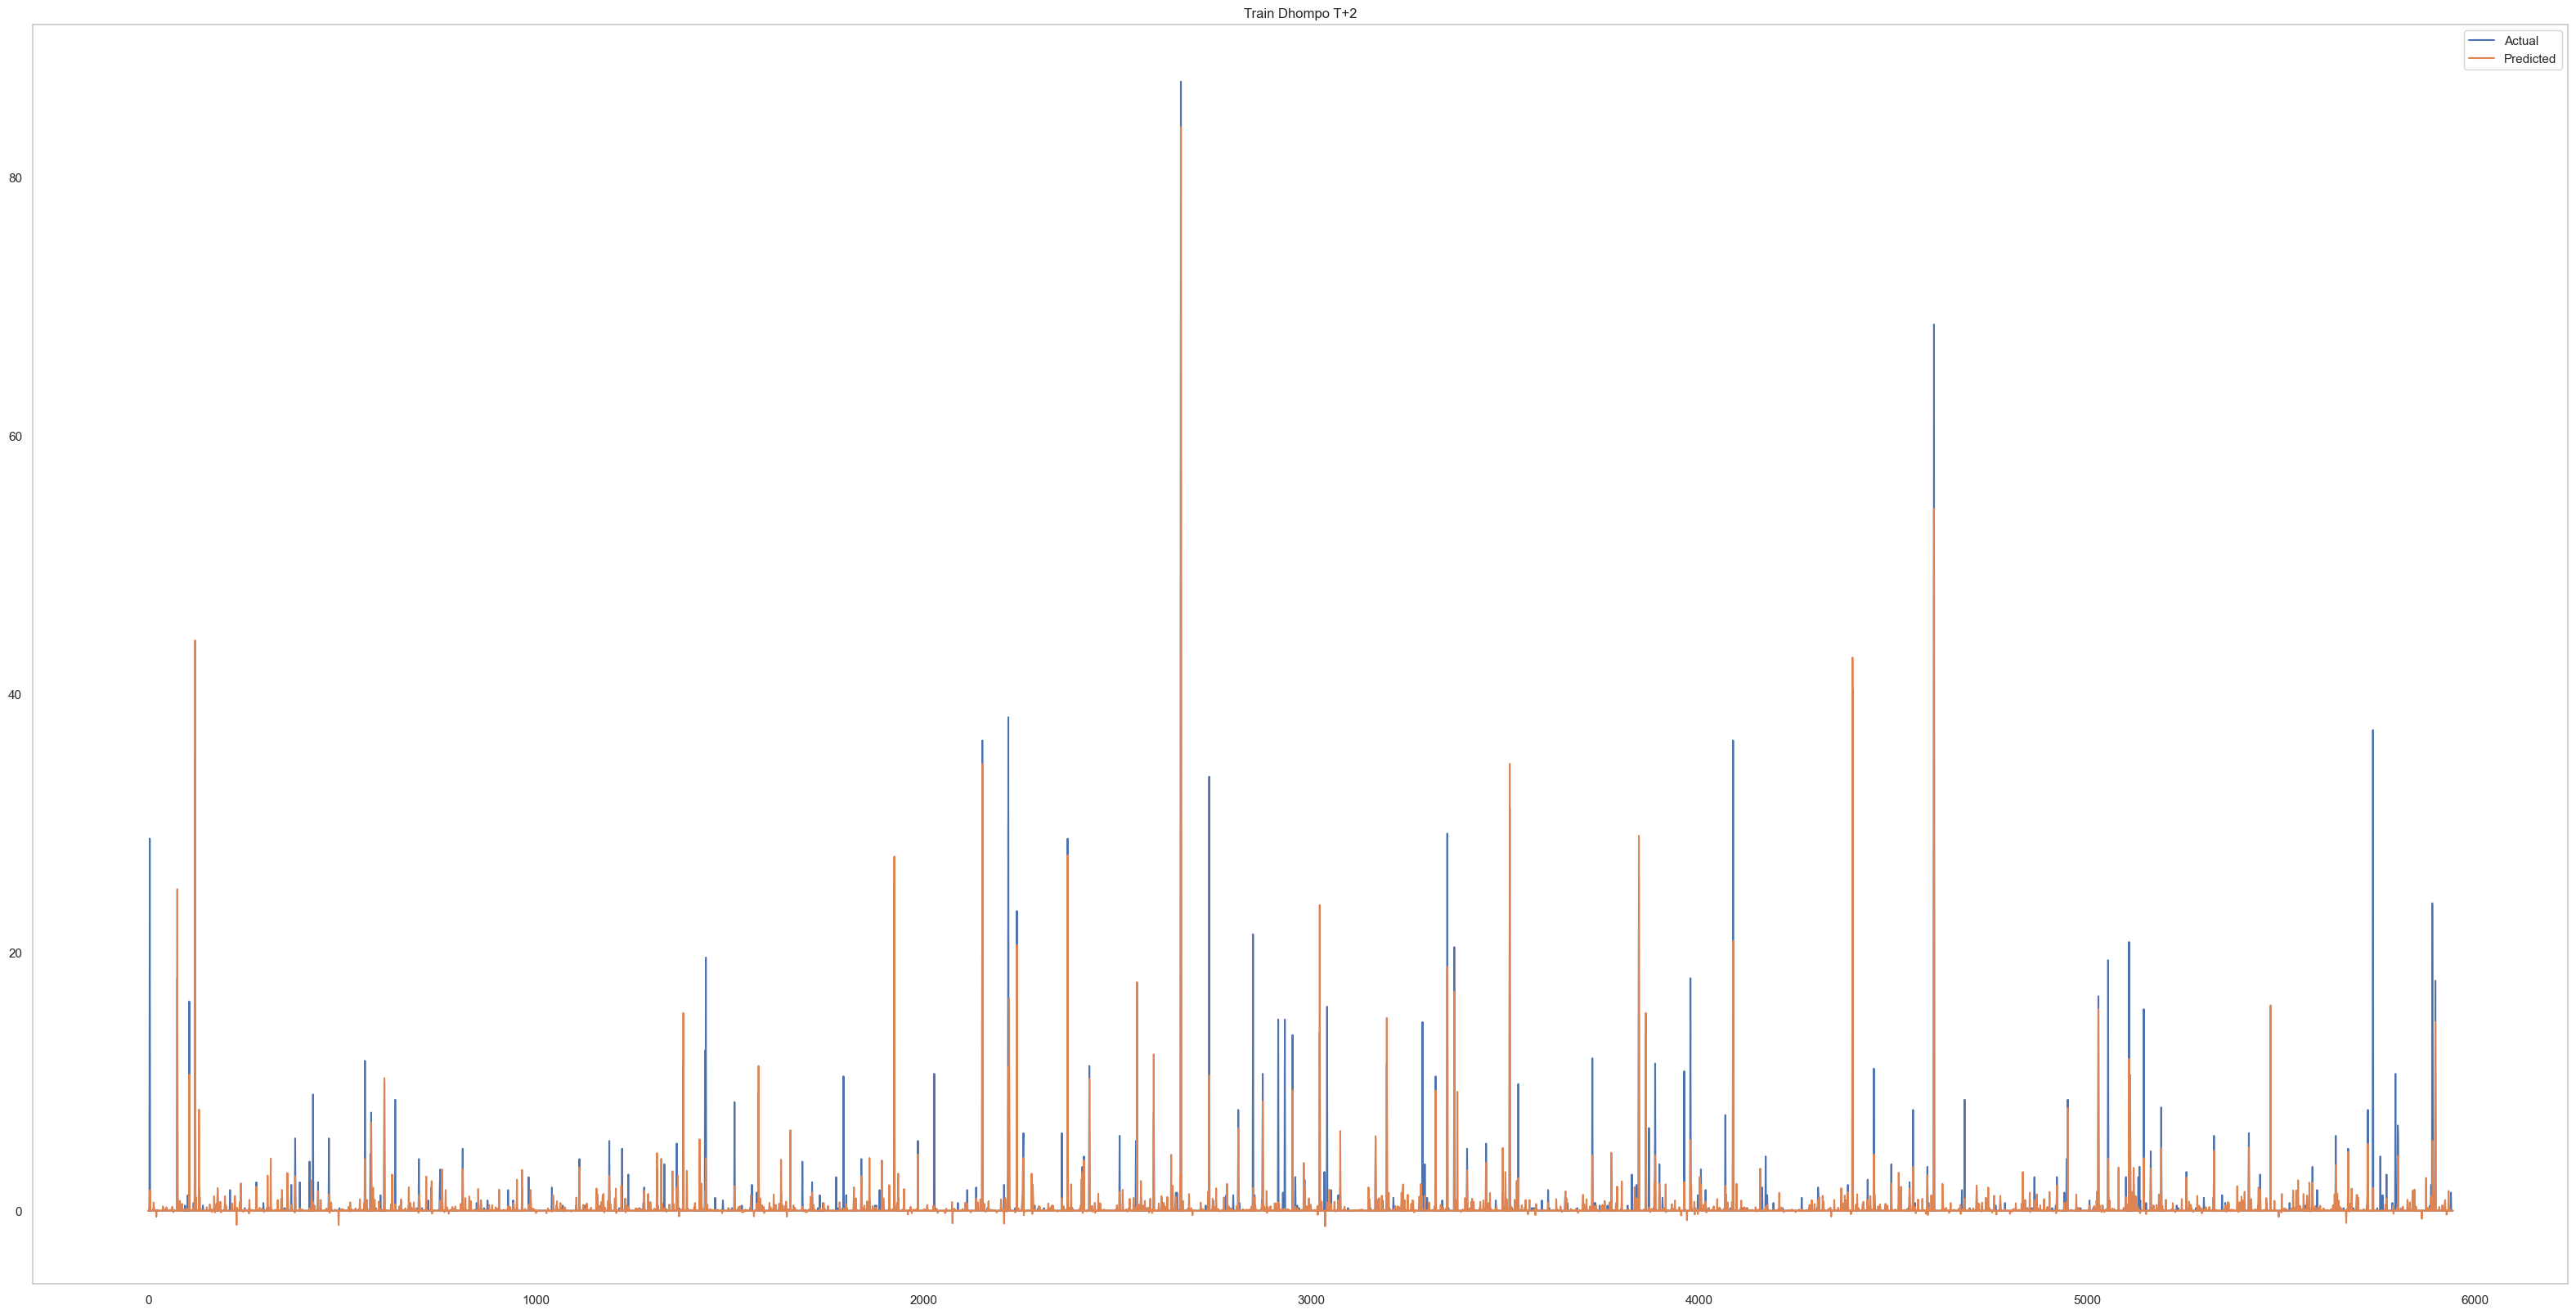

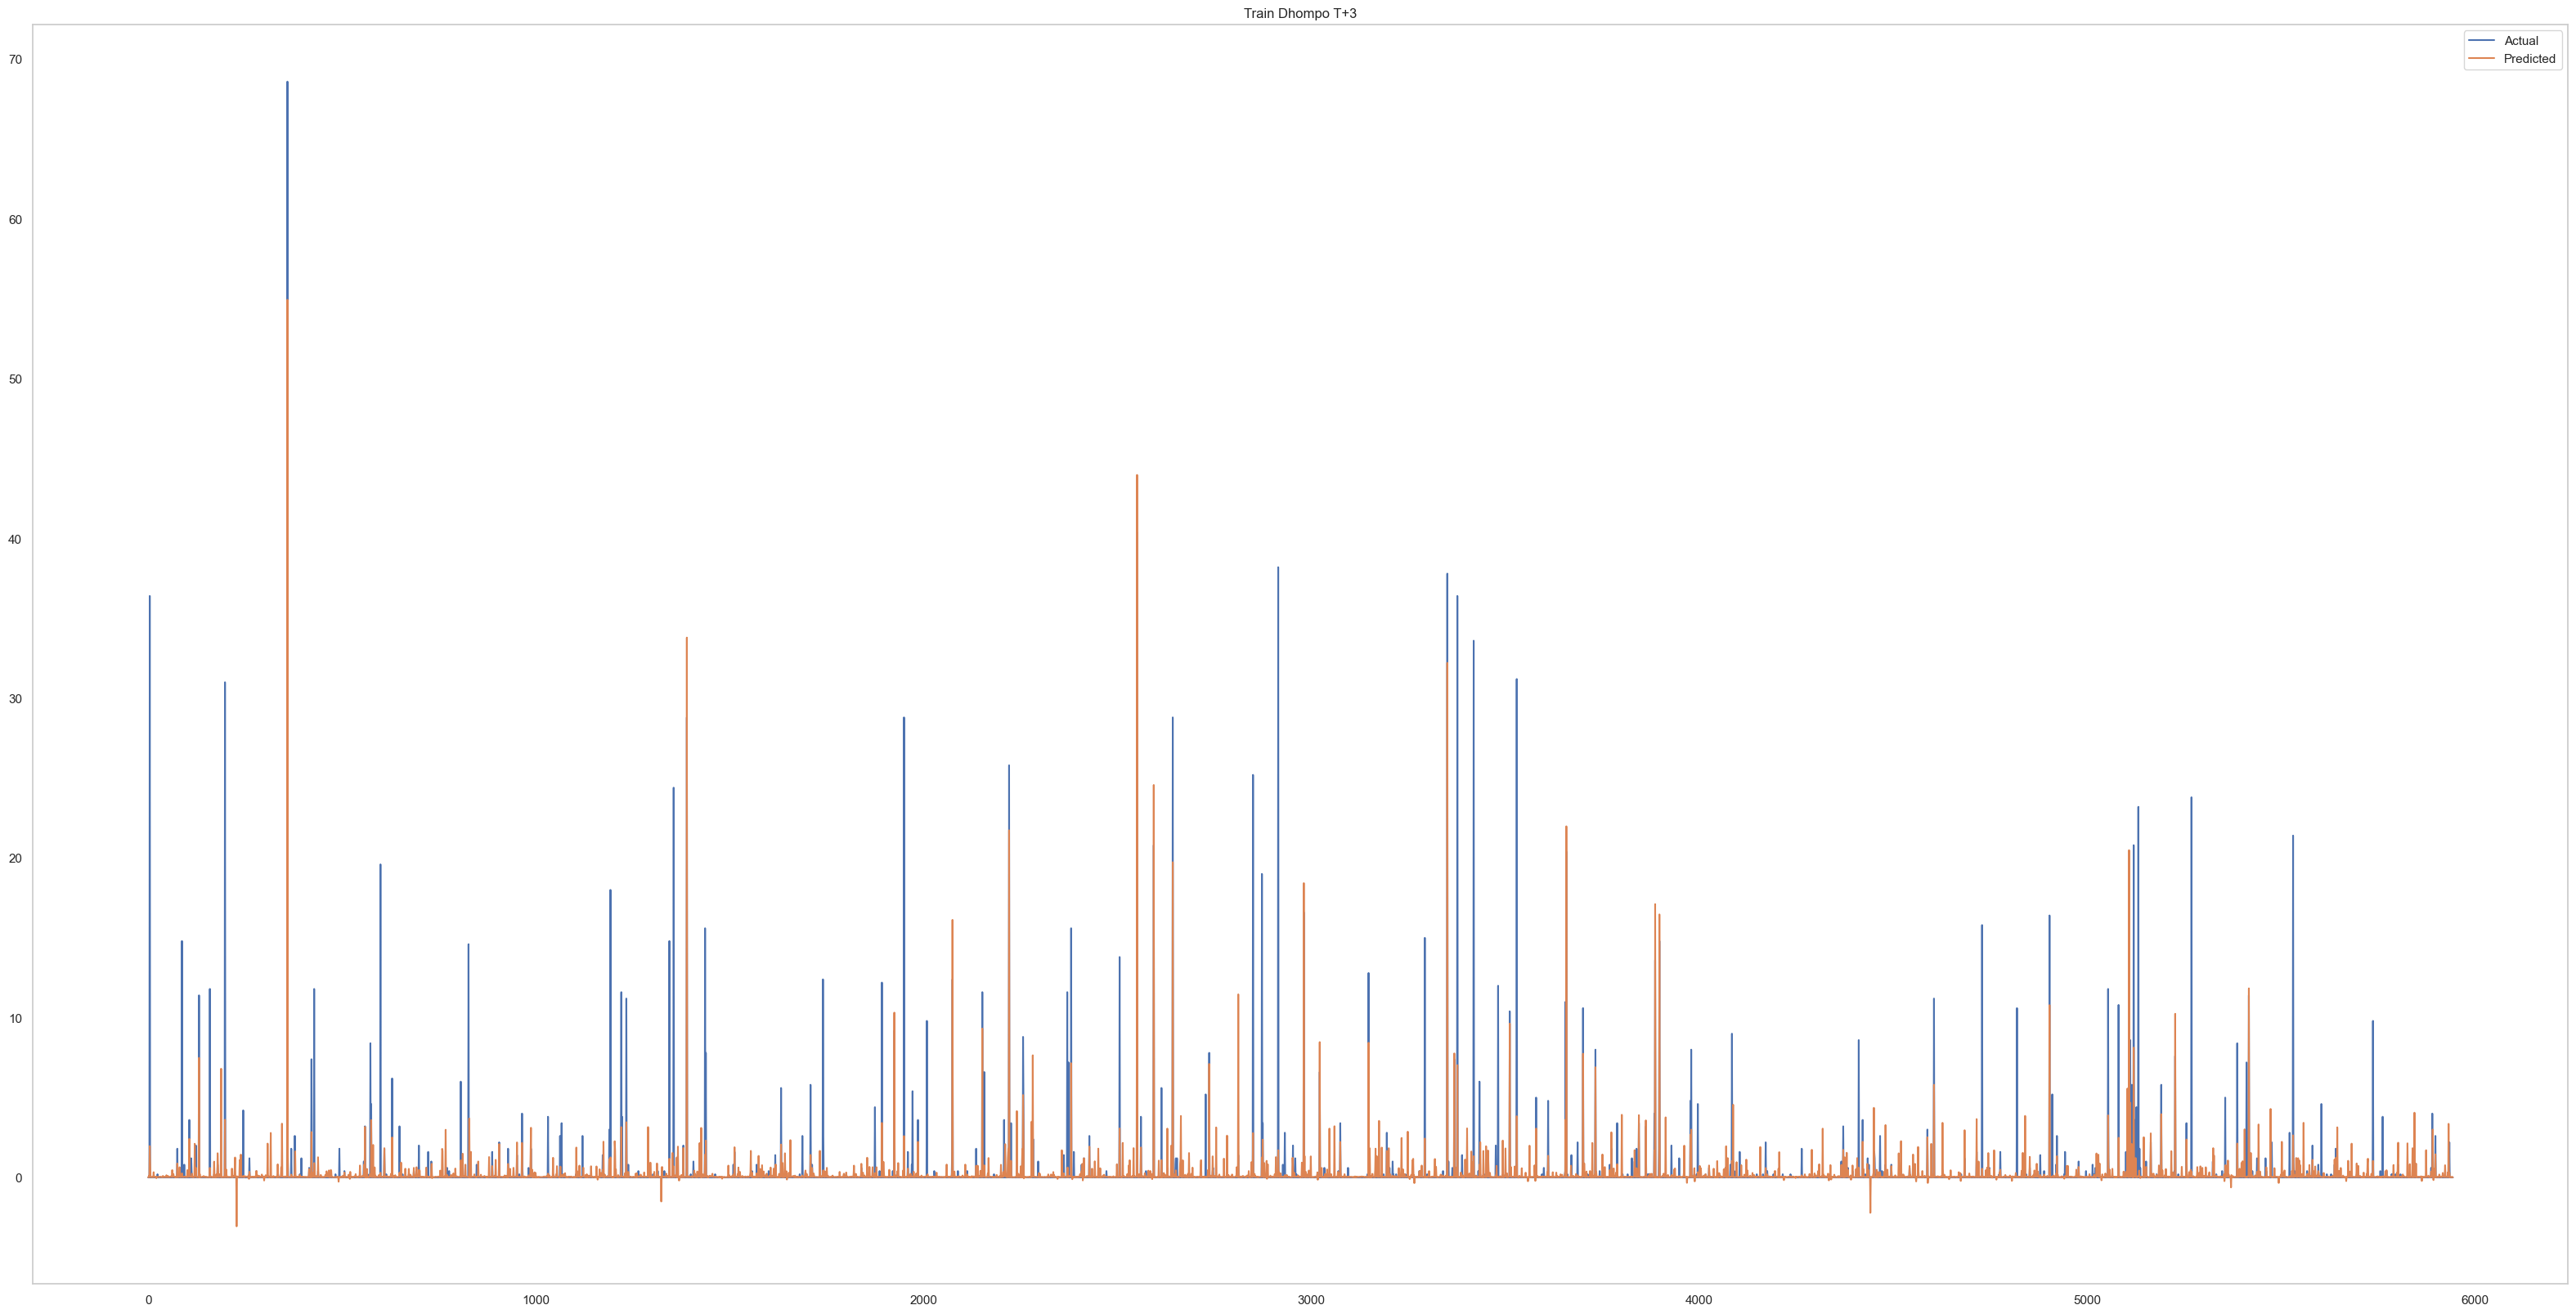

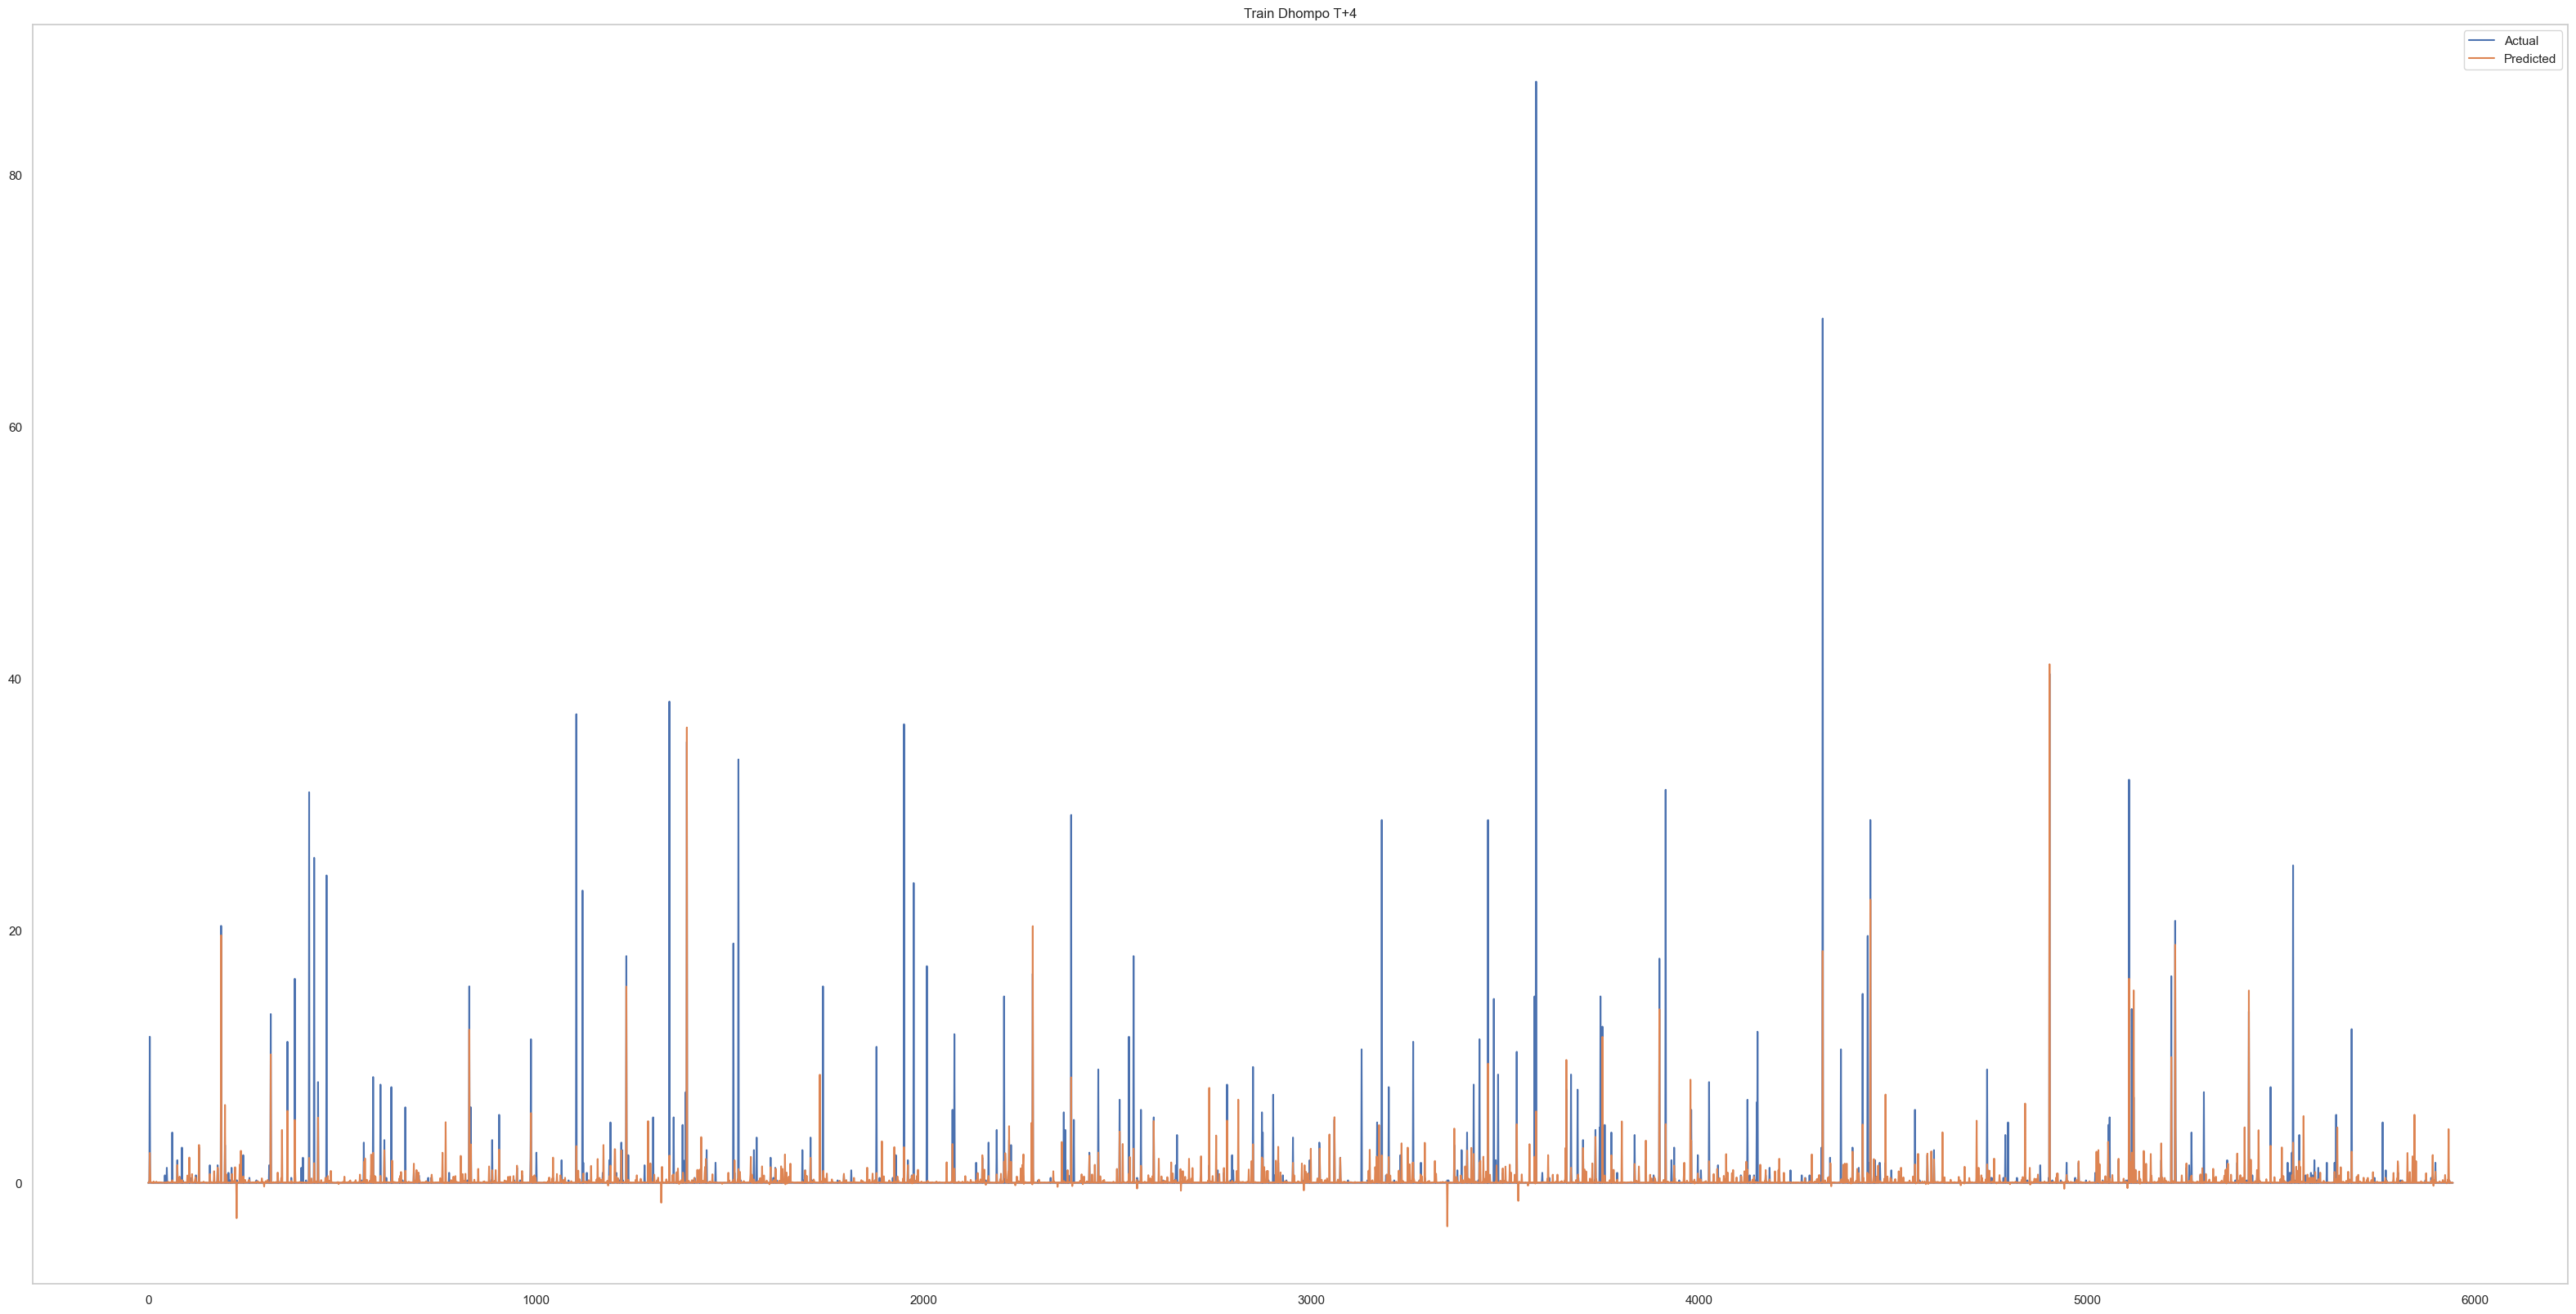

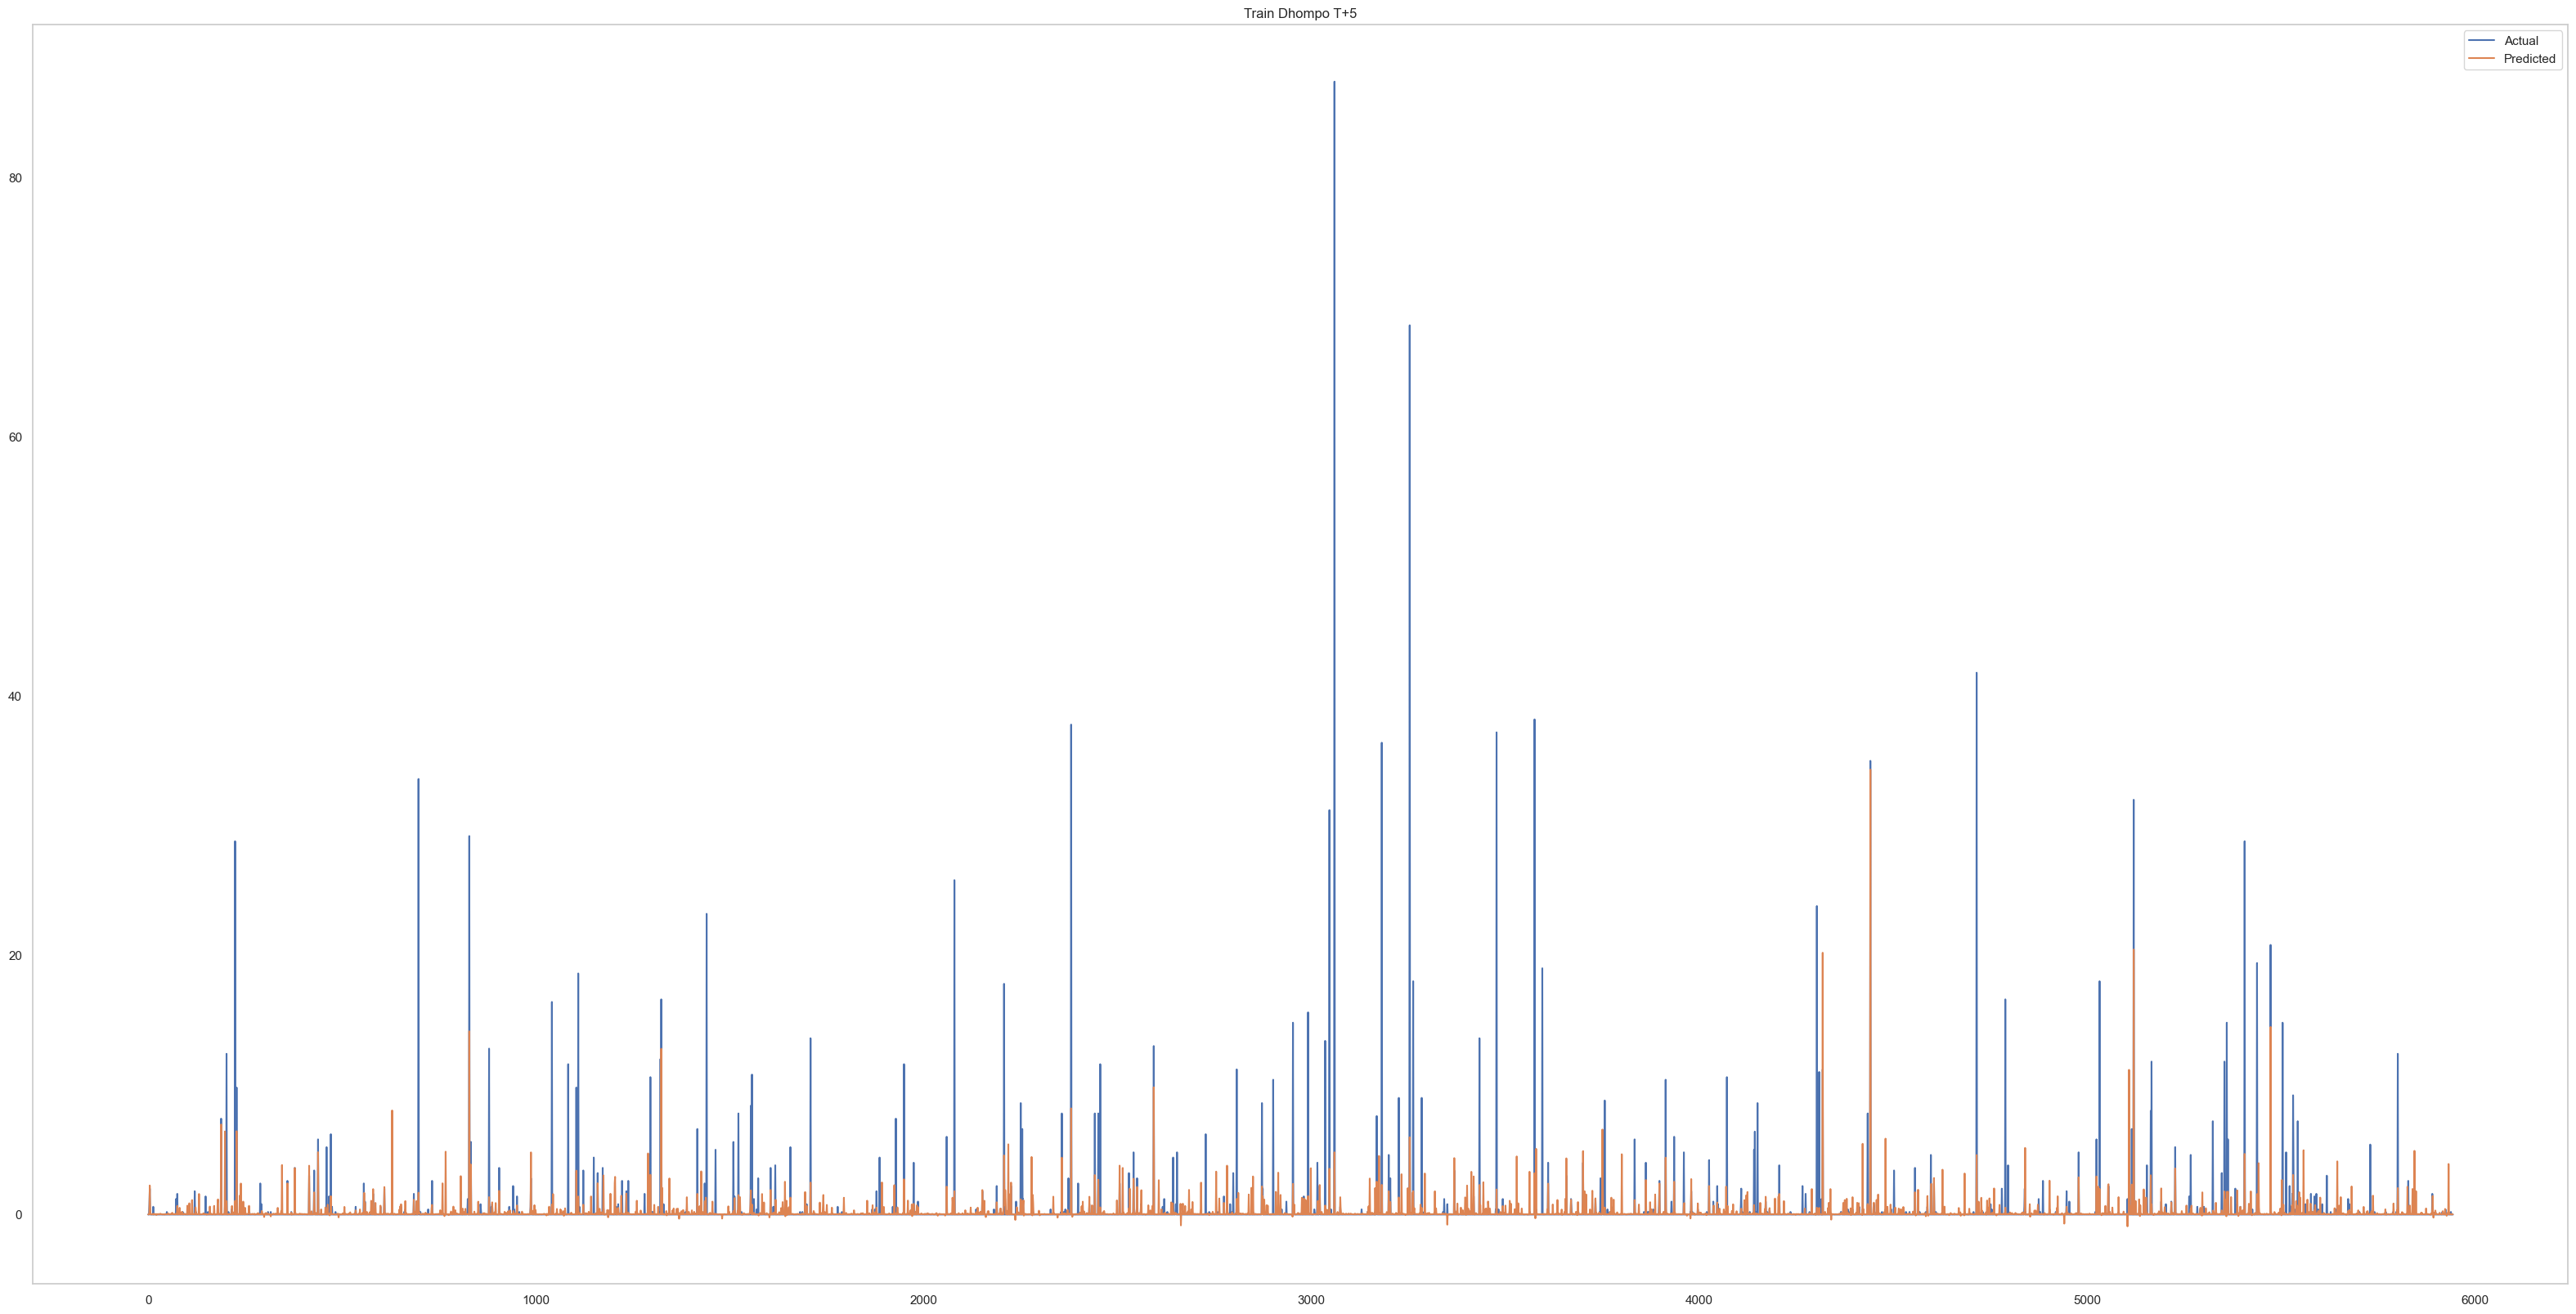

In [247]:
for i in range(0,n_steps_out):
    mpl.rcParams['figure.figsize'] = (40,20)
    mpl.rcParams['axes.grid'] = False
    ax = df_final_train[i][['Tinggi Muka Air Dhompo', 'Prediksi Tinggi Muka Air Dhompo']].plot()
    ax.legend(["Actual", "Predicted"]) 
    ax.set_title(f"Train Dhompo T+{i+1}")

In [248]:
rmse_scores = []
model_names = []
mse_scores = []
mape_scores = []
mae_scores = []

In [249]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_percentage_error

indicator = ['Tinggi Muka Air Dhompo']

for j in range(0,n_steps_out): 
  for i in indicator:
    rmse_scores.append(mean_squared_error(df_final[j][f'{i}'],df_final[j][f'Prediksi {i}'], squared=False))
    mse_scores.append(mean_squared_error(df_final[j][f'{i}'],df_final[j][f'Prediksi {i}']))
    mae_scores.append(mean_absolute_error(df_final[j][f'{i}'], df_final[j][f'Prediksi {i}']))
    mape_scores.append(mean_absolute_percentage_error(df_final[j][f'{i}'], df_final[j][f'Prediksi {i}']))
    model_names.append(f"{i} T+{j+1}")

In [250]:
if all(len(arr) == len(model_names) for arr in [rmse_scores, mse_scores, mae_scores, mape_scores]):
    data = {'Fitur Yang Akan Diprediksi': model_names,
            'RMSE Score Prediction': rmse_scores,
            'MSE Score Prediction': mse_scores,
            'MAE Score Prediction': mae_scores,
            'MAPE Score Prediction': mape_scores}

    df_evaluation = pd.DataFrame(data)
    df_evaluation = df_evaluation.sort_values(by='RMSE Score Prediction', ascending=True)
    pd.set_option('display.float_format', '{:.2f}'.format)
    df_evaluation
else:
    print("Arrays have different lengths.")